![header](images/header.jpg)

# Predicting Condition of Tanzanian Water Wells

**Author:** [Jonathan Fetterolf](mailto:jonathan.fetterolf@gmail.com)

## Overview

## Business Understanding and Business Problem
Build a classification model to predict whether a pump is functional, needs some repairs, or doesn't work at all. Data driven predictions will lead to more efficient maintenance operations and will ensure clean and potable water is available to communities across Tanzania. 

### Cost of Errors
Tanzania has an area of 364,900 mi² which makes it the 30th largest country in the world. According to [trade.gov](https://www.trade.gov/country-commercial-guides/tanzania-construction), the managed national road network consists of 21058 miles of roadway, comprising 7944 miles of trunk and 13114 miles of regional roads. Due to the size of the country and the condition of infrastructure, it is important to only deploy maintenance and repair efforts to the locations that are positively in need of repair. 

Constructing a well in Tanzania can cost upwards of $10000 ([The Living Water Project](https://www.livingwaterwells.org/faqs)) depending on factors such as:
- cost of goods and labor
- necessary drilling depth
- amount of rock to drill through
- location of well
- cost of fuel (drilling and transportation)

Pumps in wells generally last 10 or more years but their parts do have a finite life span. The cost of repairing a well can range from a few hundred dollars to several thousand dollars. Sending repair efforts to wells that are predicted to need repairs but are in fact functioning (a false negative) use costly resources that could be put toward the wells that are actually in need of repair. 

## Data Understanding
Data for this project is from [Taarifa](http://taarifa.org/) and the [Tanzanian Ministry of Water](http://maji.go.tz/).

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

## Import Initial Data

In [2]:
df = pd.read_csv('data/training_set_values.csv', index_col='id')

## Functions/Classes


In [3]:
def null_info(col_name, df_name=df):
    '''
    give this function a column name and name of the DataFrame to
    receive a printout with how many null values the column contains,
    the percentage of missing values in that column, the top 5 values
    of the column, and how many unique values are in the column. 
    '''
    percent = round((df_name[col_name].isna().sum() / df_length) * 100, ndigits=2)
    values = df_name[col_name].value_counts().head()
    num_unique = len(list(df_name[col_name].unique()))
    col_type = df_name[col_name].dtypes
    total_nulls = df_name[col_name].isna().sum()
    return print(f'''Column Name: '{col_name}'\n
This column consists of {col_type}s and has {total_nulls} null values.\n
The percentage of missing values in the {col_name} \
column is {percent}%.\n
The top values in {col_name} are:\n
{values}\n
There are {num_unique} unique values in this column.
    ''')

In [4]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )
        return ax

## Pipelines & Transformers

In [5]:
num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss',StandardScaler())
])

In [6]:
cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [7]:
CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, selector(dtype_include=np.number)),
    ('cat_trans', cat_pipe, selector(dtype_include=object))
],remainder='passthrough')

## Data Understanding

In [8]:
df_length = len(df)
df_length

59400

In [9]:
col_names = list(df.columns)
num_cols = len(col_names)

print(f'The column names are: {col_names}\nNumber of columns: {num_cols}')

The column names are: ['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
Number of columns: 39


### About the columns:
amount_tsh - Total static head (amount water available to waterpoint)<br>
date_recorded - The date the row was entered<br>
funder - Who funded the well<br>
gps_height - Altitude of the well<br>
installer - Organization that installed the well<br>
longitude - GPS coordinate<br>
latitude - GPS coordinate<br>
wpt_name - Name of the waterpoint if there is one<br>
num_private - <br>
basin - Geographic water basin<br>
subvillage - Geographic location<br>
region - Geographic location<br>
region_code - Geographic location (coded)<br>
district_code - Geographic location (coded)<br>
lga - Geographic location<br>
ward - Geographic location<br>
population - Population around the well<br>
public_meeting - True/False<br>
recorded_by - Group entering this row of data<br>
scheme_management - Who operates the waterpoint<br>
scheme_name - Who operates the waterpoint<br>
permit - If the waterpoint is permitted<br>
construction_year - Year the waterpoint was constructed<br>
extraction_type - The kind of extraction the waterpoint uses<br>
extraction_type_group - The kind of extraction the waterpoint uses<br>
extraction_type_class - The kind of extraction the waterpoint uses<br>
management - How the waterpoint is managed<br>
management_group - How the waterpoint is managed<br>
payment - What the water costs<br>
payment_type - What the water costs<br>
water_quality - The quality of the water<br>
quality_group - The quality of the water<br>
quantity - The quantity of water<br>
quantity_group - The quantity of water<br>
source - The source of the water<br>
source_type - The source of the water<br>
source_class - The source of the water<br>
waterpoint_type - The kind of waterpoint<br>
waterpoint_type_group - The kind of waterpoint<br>

In [10]:
# let's see what we're working with
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Joining Original DataFrame with Target

The condition labels are in a separate DataFrame so we need to bring them in.

In [11]:
df_target = pd.read_csv('data/training_set_labels.csv', index_col='id')

In [12]:
df_target.columns

Index(['status_group'], dtype='object')

In [13]:
df_target.info(),
df_target.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status_group  59400 non-null  object
dtypes: object(1)
memory usage: 928.1+ KB


,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [14]:
# looks like we have the same number of rows.
df_target.shape, df.shape

((59400, 1), (59400, 39))

In [15]:
df = df.join(df_target)

In [16]:
# okay, our data is consolidated
df.shape

(59400, 40)

In [17]:
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


What are we looking at?

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

In [19]:
df.index.value_counts().sum()

59400

The index column, 'id' is a unique identifier for each row in the DataFrame

In [20]:
df.wpt_name.value_counts()

none                     3563
Shuleni                  1748
Zahanati                  830
Msikitini                 535
Kanisani                  323
                         ... 
Dp10(Kanisani)              1
Kwa Athumani Mtinangi       1
Joseph John                 1
Msivi B                     1
Kwa Shabani Abdalah         1
Name: wpt_name, Length: 37400, dtype: int64

The 'wpt_name' column is interesting because most waterpoints have names and some of those names are repeated and show up frequently.

In [21]:
df.num_private.value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [22]:
percent_of_zeroes = round(100 * (df.num_private.value_counts()[0]/len(df.num_private)))

print(f'Zero is the most common value in "num_private" and it makes up approximately {percent_of_zeroes}% of entries.')

Zero is the most common value in "num_private" and it makes up approximately 99.0% of entries.


All of the following columns describe the geographic location: 
'longitude', 'latitude', 'basin', 'subvillage', 'region', 'region_code', 'distric_code', 'lga', 'ward'

In [23]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


I need to look into the 'construction_year' column because it has a minimum year of '0'.

In [24]:
year_zero_percent = round(100 * df.construction_year.value_counts(ascending=False)\
      [0]/len(df.construction_year), ndigits=2)
print(f'{year_zero_percent}% of the values in the column are zero')

34.86% of the values in the column are zero


I will have to remove all values of zero, filling them as null values and decide how to proceed when dealing with other null values.

In [25]:
df['construction_year'] = df['construction_year'].replace({0:np.NaN})

In [26]:
df.construction_year.head()

id
69572    1999.0
8776     2010.0
34310    2009.0
67743    1986.0
19728       NaN
Name: construction_year, dtype: float64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

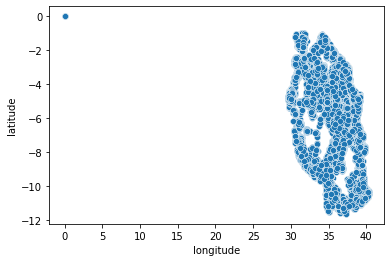

In [27]:
fig0, ax0 = plt.subplots()

sns.scatterplot(data=df, x='longitude', y='latitude', ax=ax0)

The latitudinal and longitudinal values do not make sense for this value, we'll have to convert to NaN and let the numeric imputer handle it.

In [28]:
#changing longitudinal values < 20 to np.NaN
df['longitude'].mask(df['longitude'] < 20 , np.NaN, inplace=True)
#changing latitudinal values > .5 to np.NaN
df['latitude'].mask(df['latitude'] > .5 , np.NaN, inplace=True)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

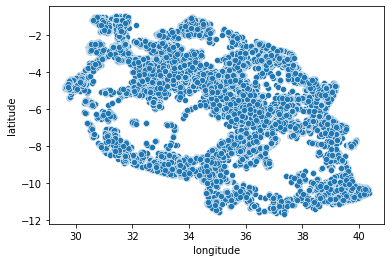

In [29]:
fig1, ax1 = plt.subplots()

sns.scatterplot(data=df, x='longitude', y='latitude', ax=ax1)

### Addressing Null Values

In [30]:
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                 1812
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year        20709
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

#### 'funder'

In [31]:
null_info('funder')

Column Name: 'funder'

This column consists of objects and has 3635 null values.

The percentage of missing values in the funder column is 6.12%.

The top values in funder are:

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Name: funder, dtype: int64

There are 1898 unique values in this column.
    


#### 'installer'

In [32]:
null_info('installer')

Column Name: 'installer'

This column consists of objects and has 3655 null values.

The percentage of missing values in the installer column is 6.15%.

The top values in installer are:

DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
Name: installer, dtype: int64

There are 2146 unique values in this column.
    


#### 'subvillage'

In [33]:
null_info('subvillage')

Column Name: 'subvillage'

This column consists of objects and has 371 null values.

The percentage of missing values in the subvillage column is 0.62%.

The top values in subvillage are:

Madukani    508
Shuleni     506
Majengo     502
Kati        373
Mtakuja     262
Name: subvillage, dtype: int64

There are 19288 unique values in this column.
    


#### 'public_meeting'

In [34]:
null_info('public_meeting')

Column Name: 'public_meeting'

This column consists of objects and has 3334 null values.

The percentage of missing values in the public_meeting column is 5.61%.

The top values in public_meeting are:

True     51011
False     5055
Name: public_meeting, dtype: int64

There are 3 unique values in this column.
    


#### 'scheme_management'

In [35]:
null_info('scheme_management')

Column Name: 'scheme_management'

This column consists of objects and has 3877 null values.

The percentage of missing values in the scheme_management column is 6.53%.

The top values in scheme_management are:

VWC                36793
WUG                 5206
Water authority     3153
WUA                 2883
Water Board         2748
Name: scheme_management, dtype: int64

There are 13 unique values in this column.
    


#### 'scheme_name'

In [36]:
null_info('scheme_name')

Column Name: 'scheme_name'

This column consists of objects and has 28166 null values.

The percentage of missing values in the scheme_name column is 47.42%.

The top values in scheme_name are:

K                682
None             644
Borehole         546
Chalinze wate    405
M                400
Name: scheme_name, dtype: int64

There are 2697 unique values in this column.
    


I will drop this column because over 47% of the rows have missing data and the 'scheme_managment' column has the same description of, "Who operates the waterpoint."

#### 'construction_year'

In [37]:
null_info('construction_year', df)

Column Name: 'construction_year'

This column consists of float64s and has 20709 null values.

The percentage of missing values in the construction_year column is 34.86%.

The top values in construction_year are:

2010.0    2645
2008.0    2613
2009.0    2533
2000.0    2091
2007.0    1587
Name: construction_year, dtype: int64

There are 55 unique values in this column.
    


#### 'permit'

In [38]:
null_info('permit', df)

Column Name: 'permit'

This column consists of objects and has 3056 null values.

The percentage of missing values in the permit column is 5.14%.

The top values in permit are:

True     38852
False    17492
Name: permit, dtype: int64

There are 3 unique values in this column.
    


## Columns to Drop


In [39]:
cols_to_drop = ['date_recorded', 'wpt_name', 'num_private', 
                'subvillage', 'region_code', 'district_code',
                'lga', 'recorded_by', 'scheme_name', 'funder',
                'extraction_type_group', 'extraction_type_class',
                'management_group', 'payment_type', 
                'quality_group', 'quantity_group', 'source_type',
                'source_class', 'waterpoint_type_group', 
                'status_group', 'binary_status']

'date_recorded' - not relevant to model

'wpt_name' - not relevant to model

'num_private' - not relevant to model

'subvillage' - not relevant to model

'region_code' - similar info to region

'district_code' - similar info

'lga' - similar info

'recorded_by' - not relevant to model

'scheme_name' - not relevant to model

'funder' - not relevant to model

'extraction_type_group' - duplicate info

'extraction_type_class' - duplicate info

'management_group' - duplicate info

'payment_type' - duplicate info

'quality_group' - duplicate info

'quantity_group' - duplicate info

'source_type' - duplicate info

'source_class' - duplicate info

'waterpoint_type_group' - duplicate info

'status_group' - this is the target


## Modifying Target
This will make the problem into a binary classification, reducing complexity in the models.

In [40]:
df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [41]:
df['binary_status'] = df['status_group'].replace({'non functional':'needs repair', 'functional needs repair':'needs repair'})

## Exploratory Data Analysis

In [42]:
X = df.drop(cols_to_drop, axis=1)
y = df.binary_status

<AxesSubplot:xlabel='binary_status', ylabel='Count'>

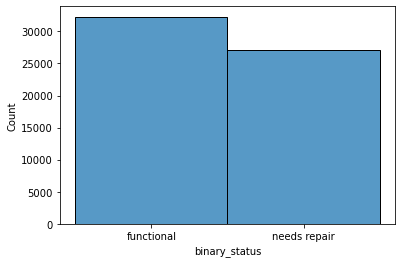

In [43]:
sns.histplot(x=y)

## Baseline Model
1st Model - "Dummy" Model

In [44]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#label encode y_train & y_test (for later use with XGBoost)
encoder = LabelEncoder()
y_train = pd.Series(encoder.fit_transform(y_train))
y_test = pd.Series(encoder.transform(y_test))

In [45]:
X.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,region,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type
id,,,,,,,,,,,,,,,,,,,,
69572,6000.0,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,Mundindi,109,True,VWC,False,1999.0,gravity,vwc,pay annually,soft,enough,spring,communal standpipe
8776,0.0,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,Natta,280,NaN,Other,True,2010.0,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe
34310,25.0,686,World vision,37.460664,-3.821329,Pangani,Manyara,Ngorika,250,True,VWC,True,2009.0,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple
67743,0.0,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,Nanyumbu,58,True,VWC,True,1986.0,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple
19728,0.0,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,Nyakasimbi,0,True,NaN,True,NaN,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe


We will predict the most frequently occuring value in 'status_group' for each row. 

In [46]:
y.value_counts(normalize=True)

functional      0.543081
needs repair    0.456919
Name: binary_status, dtype: float64

In [47]:
# Create Dummy/Baseline

dummy_model = Pipeline([
    ('ct',CT),
    ('dummy',DummyClassifier(strategy='most_frequent'))
])

In [48]:
# Use the class with out dummy pipe

dummy_model_pipe =  ModelWithCV(dummy_model, model_name='dummy',X=X_train, y=y_train)

In [49]:
dummy_model_pipe.print_cv_summary()

CV Results for `dummy` model:
            0.54233 ± 0.00007 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

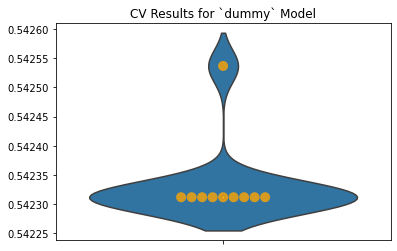

In [50]:
fig, ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)

In [51]:
dummy_model.fit(X_train, y_train)
dummy_model.score(X_test, y_test)

0.5453198653198653

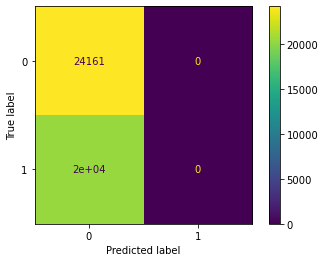

In [52]:
plot_confusion_matrix(dummy_model, X_train, y_train)

## First Simple Model
### Logistic Regression

In [56]:
logreg = LogisticRegression(verbose=2, random_state=42)
logreg_fsm = Pipeline([
    ('ct', CT),
    ('logreg', logreg)
])

In [57]:
logreg_model_pipe = ModelWithCV(logreg_fsm, model_name='logreg', X=X_train, y=y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3949     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.50310D+03

At iterate    1    f=  2.59647D+04    |proj g|=  3.36308D+03

At iterate    2    f=  2.44663D+04    |proj g|=  1.78525D+03

At iterate    3    f=  2.32051D+04    |proj g|=  1.23858D+03

At iterate    4    f=  2.24738D+04    |proj g|=  1.58610D+03

At iterate    5    f=  2.11462D+04    |proj g|=  6.78824D+02

At iterate    6    f=  2.10793D+04    |proj g|=  2.27087D+03

At iterate    7    f=  2.03537D+04    |proj g|=  4.91519D+02

At iterate    8    f=  2.02260D+04    |proj g|=  2.01858D+02

At iterate    9    f=  2.00613D+04    |proj g|=  2.81294D+02

At iterate   10    f=  1.98794D+04    |proj g|=  3.49732D+02

At iterate   11    f=  1.96441D+04    |proj g|=  5.63253D+02

At iterate   12    f=  1.95844D+04    |proj g|=  3.56485D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3957     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.42566D+03

At iterate    1    f=  2.59804D+04    |proj g|=  3.35278D+03

At iterate    2    f=  2.44883D+04    |proj g|=  1.78903D+03

At iterate    3    f=  2.32038D+04    |proj g|=  1.22401D+03

At iterate    4    f=  2.24766D+04    |proj g|=  1.55774D+03

At iterate    5    f=  2.11644D+04    |proj g|=  6.78565D+02

At iterate    6    f=  2.10863D+04    |proj g|=  2.19990D+03

At iterate    7    f=  2.03906D+04    |proj g|=  4.87168D+02

At iterate    8    f=  2.02581D+04    |proj g|=  2.02844D+02

At iterate    9    f=  2.00893D+04    |proj g|=  2.84544D+02

At iterate   10    f=  1.99086D+04    |proj g|=  3.37319D+02

At iterate   11    f=  1.96707D+04    |proj g|=  5.28578D+02

At iterate   12    f=  1.96190D+04    |proj g|=  3.23175D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3934     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.48626D+03

At iterate    1    f=  2.59464D+04    |proj g|=  3.38281D+03

At iterate    2    f=  2.44298D+04    |proj g|=  1.79389D+03

At iterate    3    f=  2.31673D+04    |proj g|=  1.24172D+03

At iterate    4    f=  2.24278D+04    |proj g|=  1.58779D+03

At iterate    5    f=  2.10867D+04    |proj g|=  6.80499D+02

At iterate    6    f=  2.09850D+04    |proj g|=  2.22177D+03

At iterate    7    f=  2.02893D+04    |proj g|=  4.81427D+02

At iterate    8    f=  2.01608D+04    |proj g|=  1.97695D+02

At iterate    9    f=  1.99964D+04    |proj g|=  2.81459D+02

At iterate   10    f=  1.98172D+04    |proj g|=  3.45400D+02

At iterate   11    f=  1.95897D+04    |proj g|=  5.65566D+02

At iterate   12    f=  1.95347D+04    |proj g|=  3.28251D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3953     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.44945D+03

At iterate    1    f=  2.59658D+04    |proj g|=  3.36191D+03

At iterate    2    f=  2.44671D+04    |proj g|=  1.78416D+03

At iterate    3    f=  2.31980D+04    |proj g|=  1.23693D+03

At iterate    4    f=  2.24628D+04    |proj g|=  1.57399D+03

At iterate    5    f=  2.11267D+04    |proj g|=  6.89372D+02

At iterate    6    f=  2.10792D+04    |proj g|=  2.32968D+03

At iterate    7    f=  2.03413D+04    |proj g|=  5.06675D+02

At iterate    8    f=  2.02134D+04    |proj g|=  2.08038D+02

At iterate    9    f=  2.00473D+04    |proj g|=  2.79444D+02

At iterate   10    f=  1.98628D+04    |proj g|=  3.58415D+02

At iterate   11    f=  1.96202D+04    |proj g|=  5.65492D+02

At iterate   12    f=  1.95656D+04    |proj g|=  3.75311D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.47600D+03

At iterate    1    f=  2.59353D+04    |proj g|=  3.39485D+03

At iterate    2    f=  2.44132D+04    |proj g|=  1.78107D+03

At iterate    3    f=  2.31535D+04    |proj g|=  1.23899D+03

At iterate    4    f=  2.24114D+04    |proj g|=  1.57832D+03

At iterate    5    f=  2.10687D+04    |proj g|=  6.79837D+02

At iterate    6    f=  2.09605D+04    |proj g|=  2.20816D+03

At iterate    7    f=  2.02665D+04    |proj g|=  4.85141D+02

At iterate    8    f=  2.01350D+04    |proj g|=  2.04706D+02

At iterate    9    f=  1.99642D+04    |proj g|=  2.89028D+02

At iterate   10    f=  1.97759D+04    |proj g|=  3.52969D+02

At iterate   11    f=  1.95492D+04    |proj g|=  6.12301D+02

At iterate   12    f=  1.94867D+04    |proj g|=  3.26749D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3942     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.45464D+03

At iterate    1    f=  2.59570D+04    |proj g|=  3.37477D+03

At iterate    2    f=  2.44498D+04    |proj g|=  1.78521D+03

At iterate    3    f=  2.31740D+04    |proj g|=  1.22328D+03

At iterate    4    f=  2.24343D+04    |proj g|=  1.58290D+03

At iterate    5    f=  2.11037D+04    |proj g|=  6.72425D+02

At iterate    6    f=  2.10066D+04    |proj g|=  2.19200D+03

At iterate    7    f=  2.03225D+04    |proj g|=  4.77535D+02

At iterate    8    f=  2.01938D+04    |proj g|=  2.04289D+02

At iterate    9    f=  2.00267D+04    |proj g|=  2.82406D+02

At iterate   10    f=  1.98422D+04    |proj g|=  3.48201D+02

At iterate   11    f=  1.96154D+04    |proj g|=  5.95815D+02

At iterate   12    f=  1.95545D+04    |proj g|=  3.23896D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.51008D+03

At iterate    1    f=  2.59442D+04    |proj g|=  3.38081D+03

At iterate    2    f=  2.44307D+04    |proj g|=  1.76618D+03

At iterate    3    f=  2.31874D+04    |proj g|=  1.22627D+03

At iterate    4    f=  2.24550D+04    |proj g|=  1.58148D+03

At iterate    5    f=  2.11299D+04    |proj g|=  6.75321D+02

At iterate    6    f=  2.10163D+04    |proj g|=  2.23285D+03

At iterate    7    f=  2.03255D+04    |proj g|=  4.87006D+02

At iterate    8    f=  2.01967D+04    |proj g|=  1.97362D+02

At iterate    9    f=  2.00308D+04    |proj g|=  2.84094D+02

At iterate   10    f=  1.98472D+04    |proj g|=  3.54687D+02

At iterate   11    f=  1.96210D+04    |proj g|=  6.02632D+02

At iterate   12    f=  1.95558D+04    |proj g|=  3.28982D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3968     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.43331D+03

At iterate    1    f=  2.59699D+04    |proj g|=  3.35511D+03

At iterate    2    f=  2.44758D+04    |proj g|=  1.76910D+03

At iterate    3    f=  2.32118D+04    |proj g|=  1.22616D+03

At iterate    4    f=  2.24743D+04    |proj g|=  1.57673D+03

At iterate    5    f=  2.11429D+04    |proj g|=  6.80583D+02

At iterate    6    f=  2.10680D+04    |proj g|=  2.28016D+03

At iterate    7    f=  2.03520D+04    |proj g|=  4.99682D+02

At iterate    8    f=  2.02219D+04    |proj g|=  2.02944D+02

At iterate    9    f=  2.00548D+04    |proj g|=  2.84421D+02

At iterate   10    f=  1.98687D+04    |proj g|=  3.54818D+02

At iterate   11    f=  1.96325D+04    |proj g|=  5.92652D+02

At iterate   12    f=  1.95742D+04    |proj g|=  3.43121D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3944     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.55821D+03

At iterate    1    f=  2.58856D+04    |proj g|=  3.43732D+03

At iterate    2    f=  2.43278D+04    |proj g|=  1.77364D+03

At iterate    3    f=  2.31091D+04    |proj g|=  1.24094D+03

At iterate    4    f=  2.23740D+04    |proj g|=  1.57264D+03

At iterate    5    f=  2.10353D+04    |proj g|=  6.78489D+02

At iterate    6    f=  2.09091D+04    |proj g|=  2.27230D+03

At iterate    7    f=  2.02090D+04    |proj g|=  4.98821D+02

At iterate    8    f=  2.00796D+04    |proj g|=  2.01502D+02

At iterate    9    f=  1.99159D+04    |proj g|=  2.84542D+02

At iterate   10    f=  1.97350D+04    |proj g|=  3.56161D+02

At iterate   11    f=  1.95017D+04    |proj g|=  5.64747D+02

At iterate   12    f=  1.94445D+04    |proj g|=  3.38558D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.45065D+03

At iterate    1    f=  2.59746D+04    |proj g|=  3.35561D+03

At iterate    2    f=  2.44803D+04    |proj g|=  1.80179D+03

At iterate    3    f=  2.31970D+04    |proj g|=  1.24684D+03

At iterate    4    f=  2.24537D+04    |proj g|=  1.59239D+03

At iterate    5    f=  2.11011D+04    |proj g|=  6.89347D+02

At iterate    6    f=  2.10648D+04    |proj g|=  2.30522D+03

At iterate    7    f=  2.03084D+04    |proj g|=  4.99342D+02

At iterate    8    f=  2.01785D+04    |proj g|=  2.07176D+02

At iterate    9    f=  2.00134D+04    |proj g|=  2.82364D+02

At iterate   10    f=  1.98273D+04    |proj g|=  3.49281D+02

At iterate   11    f=  1.95804D+04    |proj g|=  5.54839D+02

At iterate   12    f=  1.95229D+04    |proj g|=  3.85058D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


In [58]:
logreg_model_pipe.print_cv_summary()

CV Results for `logreg` model:
            0.79055 ± 0.00481 accuracy
        


<AxesSubplot: title={'center': 'CV Results for `logreg` Model'}>

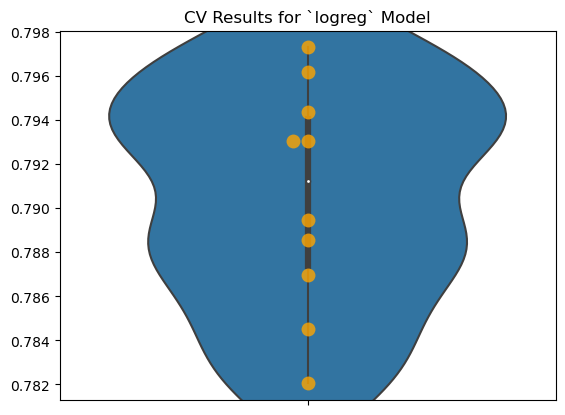

In [59]:
fig, ax = plt.subplots()

logreg_model_pipe.plot_cv(ax=ax)

In [60]:
logreg_fsm.fit(X_train, y_train)
logreg_fsm.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         4051     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08797D+04    |proj g|=  4.97193D+03

At iterate    1    f=  2.88369D+04    |proj g|=  3.75034D+03

At iterate    2    f=  2.71604D+04    |proj g|=  1.97800D+03

At iterate    3    f=  2.57576D+04    |proj g|=  1.37166D+03

At iterate    4    f=  2.49398D+04    |proj g|=  1.75467D+03

At iterate    5    f=  2.34584D+04    |proj g|=  7.55974D+02

At iterate    6    f=  2.33658D+04    |proj g|=  2.50253D+03

At iterate    7    f=  2.25777D+04    |proj g|=  5.45232D+02

At iterate    8    f=  2.24344D+04    |proj g|=  2.26023D+02

At iterate    9    f=  2.22501D+04    |proj g|=  3.14190D+02

At iterate   10    f=  2.20466D+04    |proj g|=  3.89130D+02

At iterate   11    f=  2.17884D+04    |proj g|=  6.43428D+02

At iterate   12    f=  2.17246D+04    |proj g|=  3.78258D+02

At iterate   13    f=  2.1

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished


0.7936026936026936

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


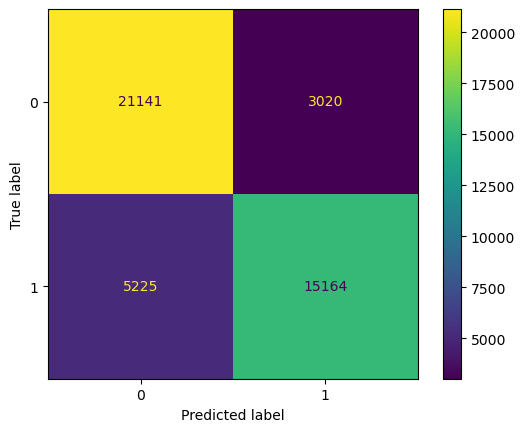

In [61]:
plot_confusion_matrix(logreg_fsm, X_train, y_train)

### Decision Tree Classifier

In [62]:
dtc = DecisionTreeClassifier(random_state=42)

dtc_fsm = Pipeline([
    ('ct', CT),
    ('dtc_fsm', dtc)
])

In [63]:
dtc_model_pipe = ModelWithCV(dtc_fsm, model_name='dtc_fsm', X=X_train, y=y_train)

In [64]:
dtc_model_pipe.print_cv_summary()

CV Results for `dtc_fsm` model:
            0.78474 ± 0.00606 accuracy
        


<AxesSubplot: title={'center': 'CV Results for `dtc_fsm` Model'}>

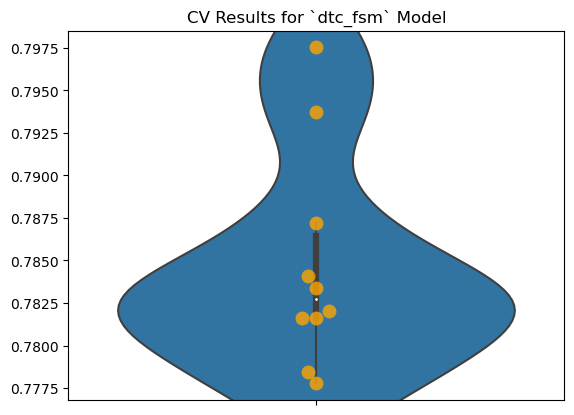

In [65]:
fig, ax = plt.subplots()

dtc_model_pipe.plot_cv(ax=ax)

In [66]:
dtc_fsm.fit(X_train, y_train)
dtc_fsm.score(X_test, y_test)

0.7841750841750842

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


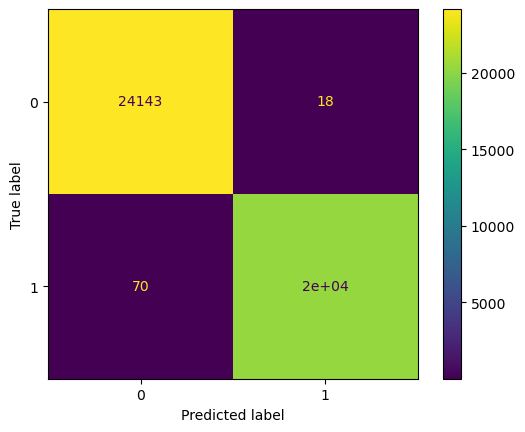

In [67]:
plot_confusion_matrix(dtc_fsm, X_train, y_train)

### Random Forest

In [68]:
rfc = RandomForestClassifier(random_state=42)

rfc_fsm = Pipeline([
    ('ct', CT),
    ('rfc_fsm', rfc)
])

In [69]:
rfc_model_pipe = ModelWithCV(rfc_fsm, model_name='rfc_fsm', X=X_train, y=y_train)

In [70]:
rfc_model_pipe.print_cv_summary()

CV Results for `rfc_fsm` model:
            0.82144 ± 0.00505 accuracy
        


<AxesSubplot: title={'center': 'CV Results for `rfc_fsm` Model'}>

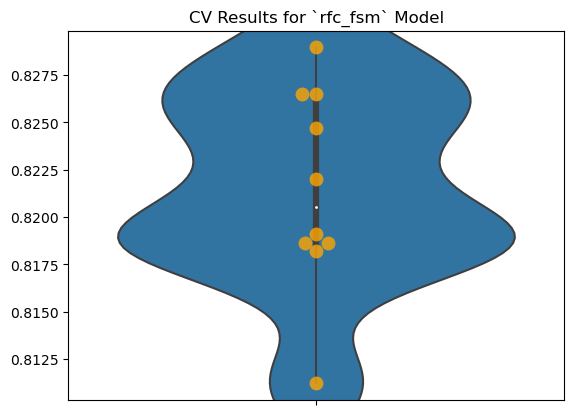

In [71]:
fig, ax = plt.subplots()

rfc_model_pipe.plot_cv(ax=ax)

In [72]:
rfc_fsm.fit(X_train, y_train)
rfc_fsm.score(X_test, y_test)

0.8173063973063973

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


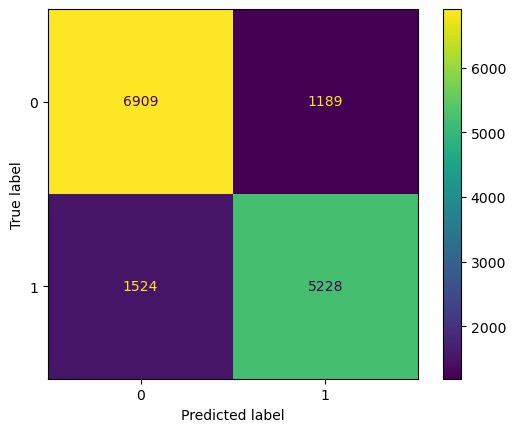

In [73]:
plot_confusion_matrix(rfc_fsm, X_test, y_test)

### Gradient Booster

In [74]:
######################################################################
######################################################################
###################...TAKING TOO LONG TO RUN...#######################
######################################################################
######################################################################

In [75]:
gbc = GradientBoostingClassifier(random_state=42)

gbc_fsm_pipe = Pipeline([
    ('ct', CT),
    ('gbc_fsm', gbc)
])

In [76]:
gbc_pipe = ModelWithCV(model=gbc_fsm_pipe,
                       model_name='gbc_pipe',
                       X=X_train,
                       y=y_train)

In [77]:
gbc_pipe.print_cv_summary()

CV Results for `gbc_pipe` model:
            0.76658 ± 0.00781 accuracy
        


<AxesSubplot: title={'center': 'CV Results for `gbc_pipe` Model'}>

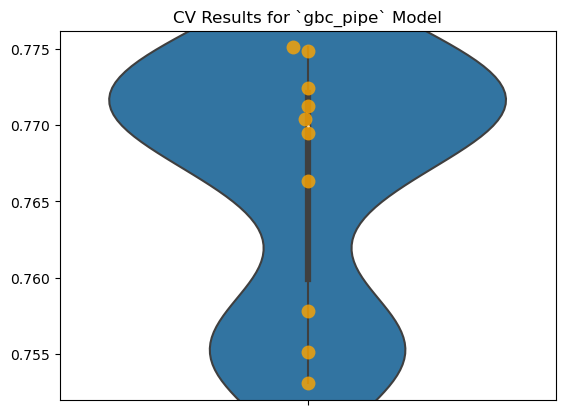

In [78]:
fig, ax = plt.subplots()

gbc_pipe.plot_cv(ax=ax)

In [79]:
gbc_fsm_pipe.fit(X_train, y_train)
gbc_fsm_pipe.score(X_test, y_test)

0.7654545454545455

### XGBoost

In [80]:
######################################################################
######################################################################
###################...TAKING TOO LONG TO RUN...#######################
######################################################################
######################################################################

In [81]:
xgb = XGBClassifier(random_state=42)

xgb_fsm_pipe = Pipeline([
    ('ct', CT),
    ('xgb_fsm', xgb)
])

In [82]:
xgb_pipe = ModelWithCV(model=xgb_fsm_pipe,
                       model_name='xgb_fsm_pipe',
                       X=X_train,
                       y=y_train)

In [83]:
xgb_pipe.print_cv_summary()

CV Results for `xgb_fsm_pipe` model:
            0.80173 ± 0.00607 accuracy
        


<AxesSubplot: title={'center': 'CV Results for `xgb_fsm_pipe` Model'}>

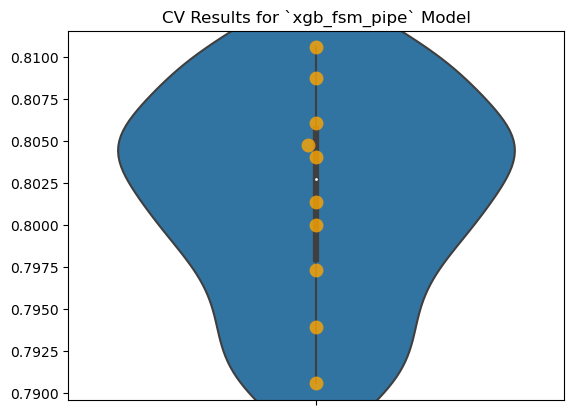

In [84]:
fig, ax = plt.subplots()

xgb_pipe.plot_cv(ax=ax)

In [85]:
xgb_fsm_pipe.fit(X_train, y_train)
xgb_fsm_pipe.score(X_test, y_test)

0.8003367003367003

## Model Choice - Logistic Regression

1. Logistic regression is faster to train than other models
2. Logistic regression is more interpretable which makes it more useful for the non-technical presentation
3. Logistic regression is less prone to overfitting

### GridSearchCV

#### 1st GridSearch

We'll check the following hyperparameters in the first GridSearch
- numeric impute strategy: 'mean', or 'median'
- logistic regression penalty: 'l1', 'l2', or 'elasticnet'
- logistic regression C value: '1e-1', '1.0', '1e2'

In [86]:
logreg_fsm

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee7aa4f040>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                

In [87]:
params = {
    'ct__num_trans__num_impute__strategy':['mean','median'],
    'logreg__penalty':['l1','l2','elasticnet'],
    'logreg__C':[1e-1,1.0,1e2]
         }
first_logreg_gs = GridSearchCV(estimator=logreg_fsm,
                              param_grid=params, cv=10, verbose=2)

In [88]:
first_logreg_gs.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l1; total time=   0.8s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l1; total time=   0.9s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l1; total time=   0.8s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l1; total time=   0.8s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l1; total time=   0.9s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l1; total time=   0.9s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l1; total time=   0.8s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l1; total time=   0.9s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l1; total time=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3949     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.50310D+03

At iterate    1    f=  2.59654D+04    |proj g|=  3.36098D+03

At iterate    2    f=  2.44687D+04    |proj g|=  1.78361D+03

At iterate    3    f=  2.32123D+04    |proj g|=  1.23605D+03

At iterate    4    f=  2.24856D+04    |proj g|=  1.58268D+03

At iterate    5    f=  2.11744D+04    |proj g|=  6.75351D+02

At iterate    6    f=  2.11173D+04    |proj g|=  2.24977D+03

At iterate    7    f=  2.04100D+04    |proj g|=  4.77793D+02

At iterate    8    f=  2.02893D+04    |proj g|=  1.95231D+02

At iterate    9    f=  2.01317D+04    |proj g|=  2.72608D+02

At iterate   10    f=  1.99627D+04    |proj g|=  3.36493D+02

At iterate   11    f=  1.97574D+04    |proj g|=  5.63969D+02

At iterate   12    f=  1.97030D+04    |proj g|=  3.14598D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l2; total time=   5.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3957     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.42566D+03

At iterate    1    f=  2.59811D+04    |proj g|=  3.35069D+03

At iterate    2    f=  2.44907D+04    |proj g|=  1.78674D+03

At iterate    3    f=  2.32111D+04    |proj g|=  1.22148D+03

At iterate    4    f=  2.24885D+04    |proj g|=  1.55436D+03

At iterate    5    f=  2.11926D+04    |proj g|=  6.75051D+02

At iterate    6    f=  2.11246D+04    |proj g|=  2.18010D+03

At iterate    7    f=  2.04461D+04    |proj g|=  4.75372D+02

At iterate    8    f=  2.03209D+04    |proj g|=  1.96281D+02

At iterate    9    f=  2.01593D+04    |proj g|=  2.75527D+02

At iterate   10    f=  1.99917D+04    |proj g|=  3.24176D+02

At iterate   11    f=  1.97812D+04    |proj g|=  5.25571D+02

At iterate   12    f=  1.97350D+04    |proj g|=  3.22685D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3934     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.48626D+03

At iterate    1    f=  2.59471D+04    |proj g|=  3.38069D+03

At iterate    2    f=  2.44324D+04    |proj g|=  1.79223D+03

At iterate    3    f=  2.31746D+04    |proj g|=  1.23918D+03

At iterate    4    f=  2.24397D+04    |proj g|=  1.58438D+03

At iterate    5    f=  2.11152D+04    |proj g|=  6.76947D+02

At iterate    6    f=  2.10242D+04    |proj g|=  2.20128D+03

At iterate    7    f=  2.03462D+04    |proj g|=  4.68003D+02

At iterate    8    f=  2.02248D+04    |proj g|=  1.91051D+02

At iterate    9    f=  2.00677D+04    |proj g|=  2.72568D+02

At iterate   10    f=  1.99013D+04    |proj g|=  3.32246D+02

At iterate   11    f=  1.97028D+04    |proj g|=  5.65431D+02

At iterate   12    f=  1.96523D+04    |proj g|=  2.96710D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3953     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.44945D+03

At iterate    1    f=  2.59665D+04    |proj g|=  3.35981D+03

At iterate    2    f=  2.44696D+04    |proj g|=  1.78253D+03

At iterate    3    f=  2.32052D+04    |proj g|=  1.23439D+03

At iterate    4    f=  2.24747D+04    |proj g|=  1.57059D+03

At iterate    5    f=  2.11552D+04    |proj g|=  6.85780D+02

At iterate    6    f=  2.11172D+04    |proj g|=  2.30834D+03

At iterate    7    f=  2.03977D+04    |proj g|=  4.92570D+02

At iterate    8    f=  2.02768D+04    |proj g|=  2.01292D+02

At iterate    9    f=  2.01177D+04    |proj g|=  2.70898D+02

At iterate   10    f=  1.99463D+04    |proj g|=  3.44762D+02

At iterate   11    f=  1.97338D+04    |proj g|=  5.67279D+02

At iterate   12    f=  1.96844D+04    |proj g|=  3.35029D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.47600D+03

At iterate    1    f=  2.59360D+04    |proj g|=  3.39273D+03

At iterate    2    f=  2.44157D+04    |proj g|=  1.77942D+03

At iterate    3    f=  2.31607D+04    |proj g|=  1.23646D+03

At iterate    4    f=  2.24234D+04    |proj g|=  1.57494D+03

At iterate    5    f=  2.10973D+04    |proj g|=  6.76338D+02

At iterate    6    f=  2.09999D+04    |proj g|=  2.18779D+03

At iterate    7    f=  2.03236D+04    |proj g|=  4.71715D+02

At iterate    8    f=  2.01993D+04    |proj g|=  1.97924D+02

At iterate    9    f=  2.00361D+04    |proj g|=  2.79973D+02

At iterate   10    f=  1.98615D+04    |proj g|=  3.39257D+02

At iterate   11    f=  1.96661D+04    |proj g|=  6.11115D+02

At iterate   12    f=  1.96081D+04    |proj g|=  3.11956D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3942     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.45464D+03

At iterate    1    f=  2.59577D+04    |proj g|=  3.37267D+03

At iterate    2    f=  2.44523D+04    |proj g|=  1.78291D+03

At iterate    3    f=  2.31812D+04    |proj g|=  1.22076D+03

At iterate    4    f=  2.24463D+04    |proj g|=  1.57945D+03

At iterate    5    f=  2.11323D+04    |proj g|=  6.68977D+02

At iterate    6    f=  2.10456D+04    |proj g|=  2.17187D+03

At iterate    7    f=  2.03789D+04    |proj g|=  4.65928D+02

At iterate    8    f=  2.02572D+04    |proj g|=  1.97732D+02

At iterate    9    f=  2.00973D+04    |proj g|=  2.73479D+02

At iterate   10    f=  1.99260D+04    |proj g|=  3.34868D+02

At iterate   11    f=  1.97293D+04    |proj g|=  5.95469D+02

At iterate   12    f=  1.96730D+04    |proj g|=  3.09817D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.51008D+03

At iterate    1    f=  2.59449D+04    |proj g|=  3.37869D+03

At iterate    2    f=  2.44332D+04    |proj g|=  1.76454D+03

At iterate    3    f=  2.31946D+04    |proj g|=  1.22377D+03

At iterate    4    f=  2.24669D+04    |proj g|=  1.57810D+03

At iterate    5    f=  2.11580D+04    |proj g|=  6.71828D+02

At iterate    6    f=  2.10553D+04    |proj g|=  2.21220D+03

At iterate    7    f=  2.03822D+04    |proj g|=  4.73422D+02

At iterate    8    f=  2.02605D+04    |proj g|=  1.90762D+02

At iterate    9    f=  2.01018D+04    |proj g|=  2.75174D+02

At iterate   10    f=  1.99315D+04    |proj g|=  3.41176D+02

At iterate   11    f=  1.97360D+04    |proj g|=  6.02033D+02

At iterate   12    f=  1.96755D+04    |proj g|=  3.02216D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l2; total time=   6.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3968     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.43331D+03

At iterate    1    f=  2.59706D+04    |proj g|=  3.35302D+03

At iterate    2    f=  2.44783D+04    |proj g|=  1.76680D+03

At iterate    3    f=  2.32190D+04    |proj g|=  1.22365D+03

At iterate    4    f=  2.24862D+04    |proj g|=  1.57333D+03

At iterate    5    f=  2.11713D+04    |proj g|=  6.77065D+02

At iterate    6    f=  2.11065D+04    |proj g|=  2.25927D+03

At iterate    7    f=  2.04084D+04    |proj g|=  4.85835D+02

At iterate    8    f=  2.02854D+04    |proj g|=  1.96347D+02

At iterate    9    f=  2.01254D+04    |proj g|=  2.75669D+02

At iterate   10    f=  1.99525D+04    |proj g|=  3.41361D+02

At iterate   11    f=  1.97467D+04    |proj g|=  5.92546D+02

At iterate   12    f=  1.96931D+04    |proj g|=  3.03583D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3944     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.55821D+03

At iterate    1    f=  2.58864D+04    |proj g|=  3.43515D+03

At iterate    2    f=  2.43305D+04    |proj g|=  1.77197D+03

At iterate    3    f=  2.31164D+04    |proj g|=  1.23843D+03

At iterate    4    f=  2.23858D+04    |proj g|=  1.56936D+03

At iterate    5    f=  2.10635D+04    |proj g|=  6.74970D+02

At iterate    6    f=  2.09486D+04    |proj g|=  2.25137D+03

At iterate    7    f=  2.02664D+04    |proj g|=  4.84916D+02

At iterate    8    f=  2.01442D+04    |proj g|=  1.94756D+02

At iterate    9    f=  1.99877D+04    |proj g|=  2.75709D+02

At iterate   10    f=  1.98199D+04    |proj g|=  3.42643D+02

At iterate   11    f=  1.96162D+04    |proj g|=  5.65069D+02

At iterate   12    f=  1.95640D+04    |proj g|=  2.98651D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=l2; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.45065D+03

At iterate    1    f=  2.59753D+04    |proj g|=  3.35352D+03

At iterate    2    f=  2.44827D+04    |proj g|=  1.80014D+03

At iterate    3    f=  2.32043D+04    |proj g|=  1.24427D+03

At iterate    4    f=  2.24657D+04    |proj g|=  1.58892D+03

At iterate    5    f=  2.11300D+04    |proj g|=  6.85808D+02

At iterate    6    f=  2.11033D+04    |proj g|=  2.28424D+03

At iterate    7    f=  2.03657D+04    |proj g|=  4.85247D+02

At iterate    8    f=  2.02431D+04    |proj g|=  2.00352D+02

At iterate    9    f=  2.00849D+04    |proj g|=  2.73628D+02

At iterate   10    f=  1.99122D+04    |proj g|=  3.35989D+02

At iterate   11    f=  1.96958D+04    |proj g|=  5.55870D+02

At iterate   12    f=  1.96443D+04    |proj g|=  3.42746D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.2s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.0s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.0s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.0s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=0.1, logreg__penalty=elasticnet; to

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3949     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.50310D+03

At iterate    1    f=  2.59647D+04    |proj g|=  3.36308D+03

At iterate    2    f=  2.44663D+04    |proj g|=  1.78525D+03

At iterate    3    f=  2.32051D+04    |proj g|=  1.23858D+03

At iterate    4    f=  2.24738D+04    |proj g|=  1.58610D+03

At iterate    5    f=  2.11462D+04    |proj g|=  6.78824D+02

At iterate    6    f=  2.10793D+04    |proj g|=  2.27087D+03

At iterate    7    f=  2.03537D+04    |proj g|=  4.91519D+02

At iterate    8    f=  2.02260D+04    |proj g|=  2.01858D+02

At iterate    9    f=  2.00613D+04    |proj g|=  2.81294D+02

At iterate   10    f=  1.98794D+04    |proj g|=  3.49732D+02

At iterate   11    f=  1.96441D+04    |proj g|=  5.63253D+02

At iterate   12    f=  1.95844D+04    |proj g|=  3.56485D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2; total time=   5.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3957     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.42566D+03

At iterate    1    f=  2.59804D+04    |proj g|=  3.35278D+03

At iterate    2    f=  2.44883D+04    |proj g|=  1.78903D+03

At iterate    3    f=  2.32038D+04    |proj g|=  1.22401D+03

At iterate    4    f=  2.24766D+04    |proj g|=  1.55774D+03

At iterate    5    f=  2.11644D+04    |proj g|=  6.78565D+02

At iterate    6    f=  2.10863D+04    |proj g|=  2.19990D+03

At iterate    7    f=  2.03906D+04    |proj g|=  4.87168D+02

At iterate    8    f=  2.02581D+04    |proj g|=  2.02844D+02

At iterate    9    f=  2.00893D+04    |proj g|=  2.84544D+02

At iterate   10    f=  1.99086D+04    |proj g|=  3.37319D+02

At iterate   11    f=  1.96707D+04    |proj g|=  5.28578D+02

At iterate   12    f=  1.96190D+04    |proj g|=  3.23175D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3934     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.48626D+03

At iterate    1    f=  2.59464D+04    |proj g|=  3.38281D+03

At iterate    2    f=  2.44298D+04    |proj g|=  1.79389D+03

At iterate    3    f=  2.31673D+04    |proj g|=  1.24172D+03

At iterate    4    f=  2.24278D+04    |proj g|=  1.58779D+03

At iterate    5    f=  2.10867D+04    |proj g|=  6.80499D+02

At iterate    6    f=  2.09850D+04    |proj g|=  2.22177D+03

At iterate    7    f=  2.02893D+04    |proj g|=  4.81427D+02

At iterate    8    f=  2.01608D+04    |proj g|=  1.97695D+02

At iterate    9    f=  1.99964D+04    |proj g|=  2.81459D+02

At iterate   10    f=  1.98172D+04    |proj g|=  3.45400D+02

At iterate   11    f=  1.95897D+04    |proj g|=  5.65566D+02

At iterate   12    f=  1.95347D+04    |proj g|=  3.28251D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3953     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.44945D+03

At iterate    1    f=  2.59658D+04    |proj g|=  3.36191D+03

At iterate    2    f=  2.44671D+04    |proj g|=  1.78416D+03

At iterate    3    f=  2.31980D+04    |proj g|=  1.23693D+03

At iterate    4    f=  2.24628D+04    |proj g|=  1.57399D+03

At iterate    5    f=  2.11267D+04    |proj g|=  6.89372D+02

At iterate    6    f=  2.10792D+04    |proj g|=  2.32968D+03

At iterate    7    f=  2.03413D+04    |proj g|=  5.06675D+02

At iterate    8    f=  2.02134D+04    |proj g|=  2.08038D+02

At iterate    9    f=  2.00473D+04    |proj g|=  2.79444D+02

At iterate   10    f=  1.98628D+04    |proj g|=  3.58415D+02

At iterate   11    f=  1.96202D+04    |proj g|=  5.65492D+02

At iterate   12    f=  1.95656D+04    |proj g|=  3.75311D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.47600D+03

At iterate    1    f=  2.59353D+04    |proj g|=  3.39485D+03

At iterate    2    f=  2.44132D+04    |proj g|=  1.78107D+03

At iterate    3    f=  2.31535D+04    |proj g|=  1.23899D+03

At iterate    4    f=  2.24114D+04    |proj g|=  1.57832D+03

At iterate    5    f=  2.10687D+04    |proj g|=  6.79837D+02

At iterate    6    f=  2.09605D+04    |proj g|=  2.20816D+03

At iterate    7    f=  2.02665D+04    |proj g|=  4.85141D+02

At iterate    8    f=  2.01350D+04    |proj g|=  2.04706D+02

At iterate    9    f=  1.99642D+04    |proj g|=  2.89028D+02

At iterate   10    f=  1.97759D+04    |proj g|=  3.52969D+02

At iterate   11    f=  1.95492D+04    |proj g|=  6.12301D+02

At iterate   12    f=  1.94867D+04    |proj g|=  3.26749D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3942     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.45464D+03

At iterate    1    f=  2.59570D+04    |proj g|=  3.37477D+03

At iterate    2    f=  2.44498D+04    |proj g|=  1.78521D+03

At iterate    3    f=  2.31740D+04    |proj g|=  1.22328D+03

At iterate    4    f=  2.24343D+04    |proj g|=  1.58290D+03

At iterate    5    f=  2.11037D+04    |proj g|=  6.72425D+02

At iterate    6    f=  2.10066D+04    |proj g|=  2.19200D+03

At iterate    7    f=  2.03225D+04    |proj g|=  4.77535D+02

At iterate    8    f=  2.01938D+04    |proj g|=  2.04289D+02

At iterate    9    f=  2.00267D+04    |proj g|=  2.82406D+02

At iterate   10    f=  1.98422D+04    |proj g|=  3.48201D+02

At iterate   11    f=  1.96154D+04    |proj g|=  5.95815D+02

At iterate   12    f=  1.95545D+04    |proj g|=  3.23896D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.51008D+03

At iterate    1    f=  2.59442D+04    |proj g|=  3.38081D+03

At iterate    2    f=  2.44307D+04    |proj g|=  1.76618D+03

At iterate    3    f=  2.31874D+04    |proj g|=  1.22627D+03

At iterate    4    f=  2.24550D+04    |proj g|=  1.58148D+03

At iterate    5    f=  2.11299D+04    |proj g|=  6.75321D+02

At iterate    6    f=  2.10163D+04    |proj g|=  2.23285D+03

At iterate    7    f=  2.03255D+04    |proj g|=  4.87006D+02

At iterate    8    f=  2.01967D+04    |proj g|=  1.97362D+02

At iterate    9    f=  2.00308D+04    |proj g|=  2.84094D+02

At iterate   10    f=  1.98472D+04    |proj g|=  3.54687D+02

At iterate   11    f=  1.96210D+04    |proj g|=  6.02632D+02

At iterate   12    f=  1.95558D+04    |proj g|=  3.28982D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2; total time=   6.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3968     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.43331D+03

At iterate    1    f=  2.59699D+04    |proj g|=  3.35511D+03

At iterate    2    f=  2.44758D+04    |proj g|=  1.76910D+03

At iterate    3    f=  2.32118D+04    |proj g|=  1.22616D+03

At iterate    4    f=  2.24743D+04    |proj g|=  1.57673D+03

At iterate    5    f=  2.11429D+04    |proj g|=  6.80583D+02

At iterate    6    f=  2.10680D+04    |proj g|=  2.28016D+03

At iterate    7    f=  2.03520D+04    |proj g|=  4.99682D+02

At iterate    8    f=  2.02219D+04    |proj g|=  2.02944D+02

At iterate    9    f=  2.00548D+04    |proj g|=  2.84421D+02

At iterate   10    f=  1.98687D+04    |proj g|=  3.54818D+02

At iterate   11    f=  1.96325D+04    |proj g|=  5.92652D+02

At iterate   12    f=  1.95742D+04    |proj g|=  3.43121D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3944     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.55821D+03

At iterate    1    f=  2.58856D+04    |proj g|=  3.43732D+03

At iterate    2    f=  2.43278D+04    |proj g|=  1.77364D+03

At iterate    3    f=  2.31091D+04    |proj g|=  1.24094D+03

At iterate    4    f=  2.23740D+04    |proj g|=  1.57264D+03

At iterate    5    f=  2.10353D+04    |proj g|=  6.78489D+02

At iterate    6    f=  2.09091D+04    |proj g|=  2.27230D+03

At iterate    7    f=  2.02090D+04    |proj g|=  4.98821D+02

At iterate    8    f=  2.00796D+04    |proj g|=  2.01502D+02

At iterate    9    f=  1.99159D+04    |proj g|=  2.84542D+02

At iterate   10    f=  1.97350D+04    |proj g|=  3.56161D+02

At iterate   11    f=  1.95017D+04    |proj g|=  5.64747D+02

At iterate   12    f=  1.94445D+04    |proj g|=  3.38558D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.45065D+03

At iterate    1    f=  2.59746D+04    |proj g|=  3.35561D+03

At iterate    2    f=  2.44803D+04    |proj g|=  1.80179D+03

At iterate    3    f=  2.31970D+04    |proj g|=  1.24684D+03

At iterate    4    f=  2.24537D+04    |proj g|=  1.59239D+03

At iterate    5    f=  2.11011D+04    |proj g|=  6.89347D+02

At iterate    6    f=  2.10648D+04    |proj g|=  2.30522D+03

At iterate    7    f=  2.03084D+04    |proj g|=  4.99342D+02

At iterate    8    f=  2.01785D+04    |proj g|=  2.07176D+02

At iterate    9    f=  2.00134D+04    |proj g|=  2.82364D+02

At iterate   10    f=  1.98273D+04    |proj g|=  3.49281D+02

At iterate   11    f=  1.95804D+04    |proj g|=  5.54839D+02

At iterate   12    f=  1.95229D+04    |proj g|=  3.85058D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2; total time=   6.4s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.3s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=elasticnet; total time

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3949     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.50310D+03

At iterate    1    f=  2.59646D+04    |proj g|=  3.36331D+03

At iterate    2    f=  2.44660D+04    |proj g|=  1.78543D+03

At iterate    3    f=  2.32044D+04    |proj g|=  1.23886D+03

At iterate    4    f=  2.24724D+04    |proj g|=  1.58648D+03

At iterate    5    f=  2.11430D+04    |proj g|=  6.79208D+02

At iterate    6    f=  2.10750D+04    |proj g|=  2.27320D+03

At iterate    7    f=  2.03474D+04    |proj g|=  4.93071D+02

At iterate    8    f=  2.02189D+04    |proj g|=  2.02616D+02

At iterate    9    f=  2.00534D+04    |proj g|=  2.82291D+02

At iterate   10    f=  1.98700D+04    |proj g|=  3.51242D+02

At iterate   11    f=  1.96311D+04    |proj g|=  5.63181D+02

At iterate   12    f=  1.95706D+04    |proj g|=  3.61529D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3957     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.42566D+03

At iterate    1    f=  2.59803D+04    |proj g|=  3.35301D+03

At iterate    2    f=  2.44880D+04    |proj g|=  1.78928D+03

At iterate    3    f=  2.32030D+04    |proj g|=  1.22428D+03

At iterate    4    f=  2.24753D+04    |proj g|=  1.55811D+03

At iterate    5    f=  2.11612D+04    |proj g|=  6.78953D+02

At iterate    6    f=  2.10820D+04    |proj g|=  2.20208D+03

At iterate    7    f=  2.03843D+04    |proj g|=  4.88500D+02

At iterate    8    f=  2.02511D+04    |proj g|=  2.03594D+02

At iterate    9    f=  2.00813D+04    |proj g|=  2.85578D+02

At iterate   10    f=  1.98992D+04    |proj g|=  3.38822D+02

At iterate   11    f=  1.96580D+04    |proj g|=  5.28923D+02

At iterate   12    f=  1.96056D+04    |proj g|=  3.23131D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3934     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.48626D+03

At iterate    1    f=  2.59463D+04    |proj g|=  3.38304D+03

At iterate    2    f=  2.44296D+04    |proj g|=  1.79407D+03

At iterate    3    f=  2.31665D+04    |proj g|=  1.24200D+03

At iterate    4    f=  2.24264D+04    |proj g|=  1.58817D+03

At iterate    5    f=  2.10835D+04    |proj g|=  6.80891D+02

At iterate    6    f=  2.09806D+04    |proj g|=  2.22403D+03

At iterate    7    f=  2.02829D+04    |proj g|=  4.82945D+02

At iterate    8    f=  2.01536D+04    |proj g|=  1.98456D+02

At iterate    9    f=  1.99884D+04    |proj g|=  2.82479D+02

At iterate   10    f=  1.98076D+04    |proj g|=  3.46902D+02

At iterate   11    f=  1.95767D+04    |proj g|=  5.65582D+02

At iterate   12    f=  1.95210D+04    |proj g|=  3.32793D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3953     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.44945D+03

At iterate    1    f=  2.59657D+04    |proj g|=  3.36214D+03

At iterate    2    f=  2.44669D+04    |proj g|=  1.78434D+03

At iterate    3    f=  2.31972D+04    |proj g|=  1.23721D+03

At iterate    4    f=  2.24615D+04    |proj g|=  1.57436D+03

At iterate    5    f=  2.11235D+04    |proj g|=  6.89768D+02

At iterate    6    f=  2.10750D+04    |proj g|=  2.33204D+03

At iterate    7    f=  2.03350D+04    |proj g|=  5.08269D+02

At iterate    8    f=  2.02063D+04    |proj g|=  2.08809D+02

At iterate    9    f=  2.00394D+04    |proj g|=  2.80424D+02

At iterate   10    f=  1.98533D+04    |proj g|=  3.59971D+02

At iterate   11    f=  1.96071D+04    |proj g|=  5.65304D+02

At iterate   12    f=  1.95518D+04    |proj g|=  3.80138D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.47600D+03

At iterate    1    f=  2.59352D+04    |proj g|=  3.39508D+03

At iterate    2    f=  2.44129D+04    |proj g|=  1.78125D+03

At iterate    3    f=  2.31527D+04    |proj g|=  1.23927D+03

At iterate    4    f=  2.24101D+04    |proj g|=  1.57869D+03

At iterate    5    f=  2.10655D+04    |proj g|=  6.80223D+02

At iterate    6    f=  2.09561D+04    |proj g|=  2.21040D+03

At iterate    7    f=  2.02601D+04    |proj g|=  4.86659D+02

At iterate    8    f=  2.01277D+04    |proj g|=  2.05481D+02

At iterate    9    f=  1.99561D+04    |proj g|=  2.90066D+02

At iterate   10    f=  1.97662D+04    |proj g|=  3.54534D+02

At iterate   11    f=  1.95357D+04    |proj g|=  6.12400D+02

At iterate   12    f=  1.94726D+04    |proj g|=  3.28848D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=l2; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3942     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.45464D+03

At iterate    1    f=  2.59569D+04    |proj g|=  3.37500D+03

At iterate    2    f=  2.44496D+04    |proj g|=  1.78547D+03

At iterate    3    f=  2.31732D+04    |proj g|=  1.22355D+03

At iterate    4    f=  2.24330D+04    |proj g|=  1.58328D+03

At iterate    5    f=  2.11005D+04    |proj g|=  6.72806D+02

At iterate    6    f=  2.10023D+04    |proj g|=  2.19422D+03

At iterate    7    f=  2.03162D+04    |proj g|=  4.78845D+02

At iterate    8    f=  2.01866D+04    |proj g|=  2.05039D+02

At iterate    9    f=  2.00188D+04    |proj g|=  2.83430D+02

At iterate   10    f=  1.98326D+04    |proj g|=  3.49723D+02

At iterate   11    f=  1.96023D+04    |proj g|=  5.95837D+02

At iterate   12    f=  1.95407D+04    |proj g|=  3.26925D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.51008D+03

At iterate    1    f=  2.59441D+04    |proj g|=  3.38104D+03

At iterate    2    f=  2.44304D+04    |proj g|=  1.76636D+03

At iterate    3    f=  2.31866D+04    |proj g|=  1.22655D+03

At iterate    4    f=  2.24537D+04    |proj g|=  1.58185D+03

At iterate    5    f=  2.11268D+04    |proj g|=  6.75707D+02

At iterate    6    f=  2.10119D+04    |proj g|=  2.23513D+03

At iterate    7    f=  2.03192D+04    |proj g|=  4.88541D+02

At iterate    8    f=  2.01896D+04    |proj g|=  1.98118D+02

At iterate    9    f=  2.00228D+04    |proj g|=  2.85118D+02

At iterate   10    f=  1.98377D+04    |proj g|=  3.56229D+02

At iterate   11    f=  1.96077D+04    |proj g|=  6.02682D+02

At iterate   12    f=  1.95419D+04    |proj g|=  3.33947D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3968     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.43331D+03

At iterate    1    f=  2.59698D+04    |proj g|=  3.35534D+03

At iterate    2    f=  2.44755D+04    |proj g|=  1.76935D+03

At iterate    3    f=  2.32110D+04    |proj g|=  1.22644D+03

At iterate    4    f=  2.24730D+04    |proj g|=  1.57711D+03

At iterate    5    f=  2.11398D+04    |proj g|=  6.80971D+02

At iterate    6    f=  2.10637D+04    |proj g|=  2.28246D+03

At iterate    7    f=  2.03457D+04    |proj g|=  5.01248D+02

At iterate    8    f=  2.02148D+04    |proj g|=  2.03698D+02

At iterate    9    f=  2.00468D+04    |proj g|=  2.85424D+02

At iterate   10    f=  1.98592D+04    |proj g|=  3.56352D+02

At iterate   11    f=  1.96194D+04    |proj g|=  5.92657D+02

At iterate   12    f=  1.95604D+04    |proj g|=  3.47857D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=l2; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3944     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.55821D+03

At iterate    1    f=  2.58855D+04    |proj g|=  3.43756D+03

At iterate    2    f=  2.43276D+04    |proj g|=  1.77382D+03

At iterate    3    f=  2.31083D+04    |proj g|=  1.24122D+03

At iterate    4    f=  2.23727D+04    |proj g|=  1.57300D+03

At iterate    5    f=  2.10322D+04    |proj g|=  6.78878D+02

At iterate    6    f=  2.09047D+04    |proj g|=  2.27461D+03

At iterate    7    f=  2.02026D+04    |proj g|=  5.00394D+02

At iterate    8    f=  2.00724D+04    |proj g|=  2.02275D+02

At iterate    9    f=  1.99078D+04    |proj g|=  2.85556D+02

At iterate   10    f=  1.97253D+04    |proj g|=  3.57704D+02

At iterate   11    f=  1.94885D+04    |proj g|=  5.64731D+02

At iterate   12    f=  1.94306D+04    |proj g|=  3.43343D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=l2; total time=   6.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.45065D+03

At iterate    1    f=  2.59745D+04    |proj g|=  3.35584D+03

At iterate    2    f=  2.44800D+04    |proj g|=  1.80197D+03

At iterate    3    f=  2.31962D+04    |proj g|=  1.24712D+03

At iterate    4    f=  2.24524D+04    |proj g|=  1.59277D+03

At iterate    5    f=  2.10978D+04    |proj g|=  6.89738D+02

At iterate    6    f=  2.10605D+04    |proj g|=  2.30753D+03

At iterate    7    f=  2.03020D+04    |proj g|=  5.00936D+02

At iterate    8    f=  2.01713D+04    |proj g|=  2.07956D+02

At iterate    9    f=  2.00053D+04    |proj g|=  2.83367D+02

At iterate   10    f=  1.98176D+04    |proj g|=  3.50798D+02

At iterate   11    f=  1.95671D+04    |proj g|=  5.54754D+02

At iterate   12    f=  1.95087D+04    |proj g|=  3.90170D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=l2; total time=   6.4s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.3s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=100.0, logreg__penalty=elas

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3949     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.30703D+03

At iterate    1    f=  2.59945D+04    |proj g|=  3.38591D+03

At iterate    2    f=  2.44644D+04    |proj g|=  1.90911D+03

At iterate    3    f=  2.30747D+04    |proj g|=  1.22236D+03

At iterate    4    f=  2.24006D+04    |proj g|=  1.43747D+03

At iterate    5    f=  2.11324D+04    |proj g|=  7.14400D+02

At iterate    6    f=  2.11027D+04    |proj g|=  1.88503D+03

At iterate    7    f=  2.03654D+04    |proj g|=  5.16593D+02

At iterate    8    f=  2.02514D+04    |proj g|=  1.83195D+02

At iterate    9    f=  2.00971D+04    |proj g|=  3.62600D+02

At iterate   10    f=  1.99370D+04    |proj g|=  3.05895D+02

At iterate   11    f=  1.97454D+04    |proj g|=  5.84973D+02

At iterate   12    f=  1.96906D+04    |proj g|=  2.82485D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3957     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.23207D+03

At iterate    1    f=  2.60089D+04    |proj g|=  3.37560D+03

At iterate    2    f=  2.44856D+04    |proj g|=  1.91911D+03

At iterate    3    f=  2.30734D+04    |proj g|=  1.20790D+03

At iterate    4    f=  2.24040D+04    |proj g|=  1.41031D+03

At iterate    5    f=  2.11497D+04    |proj g|=  7.18699D+02

At iterate    6    f=  2.11330D+04    |proj g|=  1.87554D+03

At iterate    7    f=  2.04047D+04    |proj g|=  5.24110D+02

At iterate    8    f=  2.02862D+04    |proj g|=  1.83123D+02

At iterate    9    f=  2.01278D+04    |proj g|=  3.68457D+02

At iterate   10    f=  1.99696D+04    |proj g|=  3.05003D+02

At iterate   11    f=  1.97696D+04    |proj g|=  5.27426D+02

At iterate   12    f=  1.97249D+04    |proj g|=  3.41532D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=l2; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3934     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.28602D+03

At iterate    1    f=  2.59767D+04    |proj g|=  3.40636D+03

At iterate    2    f=  2.44274D+04    |proj g|=  1.90939D+03

At iterate    3    f=  2.30331D+04    |proj g|=  1.22483D+03

At iterate    4    f=  2.23528D+04    |proj g|=  1.43545D+03

At iterate    5    f=  2.10721D+04    |proj g|=  7.20513D+02

At iterate    6    f=  2.10078D+04    |proj g|=  1.83416D+03

At iterate    7    f=  2.03004D+04    |proj g|=  5.11526D+02

At iterate    8    f=  2.01864D+04    |proj g|=  1.83998D+02

At iterate    9    f=  2.00324D+04    |proj g|=  3.63192D+02

At iterate   10    f=  1.98760D+04    |proj g|=  3.00597D+02

At iterate   11    f=  1.96923D+04    |proj g|=  5.78106D+02

At iterate   12    f=  1.96394D+04    |proj g|=  2.96119D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=l2; total time=   6.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3953     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.25069D+03

At iterate    1    f=  2.59952D+04    |proj g|=  3.38567D+03

At iterate    2    f=  2.44641D+04    |proj g|=  1.90904D+03

At iterate    3    f=  2.30647D+04    |proj g|=  1.21995D+03

At iterate    4    f=  2.23884D+04    |proj g|=  1.42438D+03

At iterate    5    f=  2.11127D+04    |proj g|=  7.35467D+02

At iterate    6    f=  2.07376D+04    |proj g|=  1.01206D+03

At iterate    7    f=  2.03697D+04    |proj g|=  4.18681D+02

At iterate    8    f=  2.01728D+04    |proj g|=  2.11149D+02

At iterate    9    f=  1.99452D+04    |proj g|=  3.75162D+02

At iterate   10    f=  1.97973D+04    |proj g|=  4.77559D+02

At iterate   11    f=  1.97060D+04    |proj g|=  1.58946D+02

At iterate   12    f=  1.96431D+04    |proj g|=  1.43908D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=l2; total time=   6.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.27137D+03

At iterate    1    f=  2.59662D+04    |proj g|=  3.41884D+03

At iterate    2    f=  2.44106D+04    |proj g|=  1.91243D+03

At iterate    3    f=  2.30177D+04    |proj g|=  1.22201D+03

At iterate    4    f=  2.23363D+04    |proj g|=  1.42414D+03

At iterate    5    f=  2.10551D+04    |proj g|=  7.25328D+02

At iterate    6    f=  2.10003D+04    |proj g|=  1.85746D+03

At iterate    7    f=  2.02804D+04    |proj g|=  5.22220D+02

At iterate    8    f=  2.01632D+04    |proj g|=  1.86535D+02

At iterate    9    f=  2.00032D+04    |proj g|=  3.75366D+02

At iterate   10    f=  1.98384D+04    |proj g|=  3.17996D+02

At iterate   11    f=  1.96574D+04    |proj g|=  6.17621D+02

At iterate   12    f=  1.95968D+04    |proj g|=  2.97772D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=l2; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3942     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.26132D+03

At iterate    1    f=  2.59853D+04    |proj g|=  3.39916D+03

At iterate    2    f=  2.44453D+04    |proj g|=  1.91798D+03

At iterate    3    f=  2.30418D+04    |proj g|=  1.20720D+03

At iterate    4    f=  2.23619D+04    |proj g|=  1.43276D+03

At iterate    5    f=  2.10912D+04    |proj g|=  7.11340D+02

At iterate    6    f=  2.10368D+04    |proj g|=  1.84434D+03

At iterate    7    f=  2.03344D+04    |proj g|=  5.12915D+02

At iterate    8    f=  2.02197D+04    |proj g|=  1.83228D+02

At iterate    9    f=  2.00630D+04    |proj g|=  3.66869D+02

At iterate   10    f=  1.99012D+04    |proj g|=  3.04166D+02

At iterate   11    f=  1.97187D+04    |proj g|=  6.05855D+02

At iterate   12    f=  1.96605D+04    |proj g|=  3.00385D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.31278D+03

At iterate    1    f=  2.59740D+04    |proj g|=  3.40510D+03

At iterate    2    f=  2.44272D+04    |proj g|=  1.89834D+03

At iterate    3    f=  2.30549D+04    |proj g|=  1.21009D+03

At iterate    4    f=  2.23818D+04    |proj g|=  1.43140D+03

At iterate    5    f=  2.11165D+04    |proj g|=  7.16100D+02

At iterate    6    f=  2.10389D+04    |proj g|=  1.85061D+03

At iterate    7    f=  2.03361D+04    |proj g|=  5.14404D+02

At iterate    8    f=  2.02219D+04    |proj g|=  1.88936D+02

At iterate    9    f=  2.00663D+04    |proj g|=  3.66826D+02

At iterate   10    f=  1.99057D+04    |proj g|=  3.09467D+02

At iterate   11    f=  1.97265D+04    |proj g|=  6.11944D+02

At iterate   12    f=  1.96626D+04    |proj g|=  2.89692D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3968     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.23885D+03

At iterate    1    f=  2.59980D+04    |proj g|=  3.38013D+03

At iterate    2    f=  2.44706D+04    |proj g|=  1.90239D+03

At iterate    3    f=  2.30789D+04    |proj g|=  1.21022D+03

At iterate    4    f=  2.24007D+04    |proj g|=  1.42711D+03

At iterate    5    f=  2.11282D+04    |proj g|=  7.27085D+02

At iterate    6    f=  2.11266D+04    |proj g|=  1.94025D+03

At iterate    7    f=  2.03681D+04    |proj g|=  5.16972D+02

At iterate    8    f=  2.02517D+04    |proj g|=  1.84349D+02

At iterate    9    f=  2.00952D+04    |proj g|=  3.66276D+02

At iterate   10    f=  1.99311D+04    |proj g|=  3.09967D+02

At iterate   11    f=  1.97347D+04    |proj g|=  6.06180D+02

At iterate   12    f=  1.96832D+04    |proj g|=  2.98192D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=l2; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3944     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.35166D+03

At iterate    1    f=  2.59172D+04    |proj g|=  3.46397D+03

At iterate    2    f=  2.43230D+04    |proj g|=  1.88837D+03

At iterate    3    f=  2.29724D+04    |proj g|=  1.22408D+03

At iterate    4    f=  2.22994D+04    |proj g|=  1.42023D+03

At iterate    5    f=  2.10220D+04    |proj g|=  7.29226D+02

At iterate    6    f=  2.09665D+04    |proj g|=  1.91776D+03

At iterate    7    f=  2.02274D+04    |proj g|=  5.12139D+02

At iterate    8    f=  2.01121D+04    |proj g|=  1.83213D+02

At iterate    9    f=  1.99594D+04    |proj g|=  3.64782D+02

At iterate   10    f=  1.98009D+04    |proj g|=  3.11293D+02

At iterate   11    f=  1.96065D+04    |proj g|=  5.71016D+02

At iterate   12    f=  1.95565D+04    |proj g|=  2.99339D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=l2; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.25832D+03

At iterate    1    f=  2.60023D+04    |proj g|=  3.38077D+03

At iterate    2    f=  2.44748D+04    |proj g|=  1.91513D+03

At iterate    3    f=  2.30629D+04    |proj g|=  1.23005D+03

At iterate    4    f=  2.23790D+04    |proj g|=  1.44182D+03

At iterate    5    f=  2.10867D+04    |proj g|=  7.29217D+02

At iterate    6    f=  2.07085D+04    |proj g|=  1.02648D+03

At iterate    7    f=  2.03341D+04    |proj g|=  4.30121D+02

At iterate    8    f=  2.01363D+04    |proj g|=  2.12019D+02

At iterate    9    f=  1.99100D+04    |proj g|=  3.78415D+02

At iterate   10    f=  1.97585D+04    |proj g|=  4.58303D+02

At iterate   11    f=  1.96671D+04    |proj g|=  1.61815D+02

At iterate   12    f=  1.96005D+04    |proj g|=  1.71513D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.3s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.0s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=0.1, logreg__pena

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3949     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.30703D+03

At iterate    1    f=  2.59938D+04    |proj g|=  3.38802D+03

At iterate    2    f=  2.44619D+04    |proj g|=  1.91152D+03

At iterate    3    f=  2.30668D+04    |proj g|=  1.22501D+03

At iterate    4    f=  2.23881D+04    |proj g|=  1.44051D+03

At iterate    5    f=  2.11036D+04    |proj g|=  7.18174D+02

At iterate    6    f=  2.10647D+04    |proj g|=  1.90269D+03

At iterate    7    f=  2.03075D+04    |proj g|=  5.30896D+02

At iterate    8    f=  2.01866D+04    |proj g|=  1.87406D+02

At iterate    9    f=  2.00252D+04    |proj g|=  3.73208D+02

At iterate   10    f=  1.98522D+04    |proj g|=  3.20385D+02

At iterate   11    f=  1.96310D+04    |proj g|=  5.88529D+02

At iterate   12    f=  1.95718D+04    |proj g|=  2.93208D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3957     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.23207D+03

At iterate    1    f=  2.60082D+04    |proj g|=  3.37769D+03

At iterate    2    f=  2.44832D+04    |proj g|=  1.92151D+03

At iterate    3    f=  2.30655D+04    |proj g|=  1.21054D+03

At iterate    4    f=  2.23914D+04    |proj g|=  1.41330D+03

At iterate    5    f=  2.11209D+04    |proj g|=  7.22509D+02

At iterate    6    f=  2.10953D+04    |proj g|=  1.88822D+03

At iterate    7    f=  2.03477D+04    |proj g|=  5.38305D+02

At iterate    8    f=  2.02222D+04    |proj g|=  1.89879D+02

At iterate    9    f=  2.00564D+04    |proj g|=  3.79463D+02

At iterate   10    f=  1.98854D+04    |proj g|=  3.15416D+02

At iterate   11    f=  1.96591D+04    |proj g|=  5.33499D+02

At iterate   12    f=  1.96096D+04    |proj g|=  3.46474D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3934     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.28602D+03

At iterate    1    f=  2.59760D+04    |proj g|=  3.40849D+03

At iterate    2    f=  2.44249D+04    |proj g|=  1.91182D+03

At iterate    3    f=  2.30252D+04    |proj g|=  1.22750D+03

At iterate    4    f=  2.23402D+04    |proj g|=  1.43847D+03

At iterate    5    f=  2.10430D+04    |proj g|=  7.24359D+02

At iterate    6    f=  2.09686D+04    |proj g|=  1.84833D+03

At iterate    7    f=  2.02419D+04    |proj g|=  5.25502D+02

At iterate    8    f=  2.01209D+04    |proj g|=  1.85906D+02

At iterate    9    f=  1.99596D+04    |proj g|=  3.74047D+02

At iterate   10    f=  1.97904D+04    |proj g|=  3.15055D+02

At iterate   11    f=  1.95781D+04    |proj g|=  5.81593D+02

At iterate   12    f=  1.95214D+04    |proj g|=  2.98136D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3953     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.25069D+03

At iterate    1    f=  2.59945D+04    |proj g|=  3.38777D+03

At iterate    2    f=  2.44616D+04    |proj g|=  1.91144D+03

At iterate    3    f=  2.30569D+04    |proj g|=  1.22260D+03

At iterate    4    f=  2.23758D+04    |proj g|=  1.42739D+03

At iterate    5    f=  2.10837D+04    |proj g|=  7.39367D+02

At iterate    6    f=  2.06967D+04    |proj g|=  1.02749D+03

At iterate    7    f=  2.03131D+04    |proj g|=  4.28087D+02

At iterate    8    f=  2.01051D+04    |proj g|=  2.16851D+02

At iterate    9    f=  1.98619D+04    |proj g|=  3.85445D+02

At iterate   10    f=  1.96942D+04    |proj g|=  4.85023D+02

At iterate   11    f=  1.95908D+04    |proj g|=  1.68080D+02

At iterate   12    f=  1.95147D+04    |proj g|=  1.64043D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__penalty=l2; total time=   6.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.27137D+03

At iterate    1    f=  2.59654D+04    |proj g|=  3.42098D+03

At iterate    2    f=  2.44081D+04    |proj g|=  1.91486D+03

At iterate    3    f=  2.30097D+04    |proj g|=  1.22466D+03

At iterate    4    f=  2.23237D+04    |proj g|=  1.42711D+03

At iterate    5    f=  2.10260D+04    |proj g|=  7.29137D+02

At iterate    6    f=  2.09613D+04    |proj g|=  1.86999D+03

At iterate    7    f=  2.02218D+04    |proj g|=  5.36416D+02

At iterate    8    f=  2.00975D+04    |proj g|=  1.91469D+02

At iterate    9    f=  1.99299D+04    |proj g|=  3.86377D+02

At iterate   10    f=  1.97516D+04    |proj g|=  3.33322D+02

At iterate   11    f=  1.95394D+04    |proj g|=  6.23157D+02

At iterate   12    f=  1.94751D+04    |proj g|=  3.06788D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__penalty=l2; total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3942     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.26132D+03

At iterate    1    f=  2.59845D+04    |proj g|=  3.40128D+03

At iterate    2    f=  2.44428D+04    |proj g|=  1.92040D+03

At iterate    3    f=  2.30339D+04    |proj g|=  1.20984D+03

At iterate    4    f=  2.23492D+04    |proj g|=  1.43581D+03

At iterate    5    f=  2.10622D+04    |proj g|=  7.15092D+02

At iterate    6    f=  2.09980D+04    |proj g|=  1.85708D+03

At iterate    7    f=  2.02765D+04    |proj g|=  5.26883D+02

At iterate    8    f=  2.01549D+04    |proj g|=  1.89985D+02

At iterate    9    f=  1.99909D+04    |proj g|=  3.77787D+02

At iterate   10    f=  1.98160D+04    |proj g|=  3.18798D+02

At iterate   11    f=  1.96036D+04    |proj g|=  6.10348D+02

At iterate   12    f=  1.95417D+04    |proj g|=  3.09411D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.31278D+03

At iterate    1    f=  2.59733D+04    |proj g|=  3.40723D+03

At iterate    2    f=  2.44246D+04    |proj g|=  1.90077D+03

At iterate    3    f=  2.30470D+04    |proj g|=  1.21271D+03

At iterate    4    f=  2.23693D+04    |proj g|=  1.43438D+03

At iterate    5    f=  2.10879D+04    |proj g|=  7.19884D+02

At iterate    6    f=  2.09999D+04    |proj g|=  1.86336D+03

At iterate    7    f=  2.02778D+04    |proj g|=  5.28463D+02

At iterate    8    f=  2.01566D+04    |proj g|=  1.90933D+02

At iterate    9    f=  1.99936D+04    |proj g|=  3.77755D+02

At iterate   10    f=  1.98198D+04    |proj g|=  3.24298D+02

At iterate   11    f=  1.96100D+04    |proj g|=  6.16634D+02

At iterate   12    f=  1.95424D+04    |proj g|=  2.96395D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3968     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.23885D+03

At iterate    1    f=  2.59972D+04    |proj g|=  3.38224D+03

At iterate    2    f=  2.44681D+04    |proj g|=  1.90479D+03

At iterate    3    f=  2.30710D+04    |proj g|=  1.21286D+03

At iterate    4    f=  2.23882D+04    |proj g|=  1.43012D+03

At iterate    5    f=  2.10993D+04    |proj g|=  7.30912D+02

At iterate    6    f=  2.10890D+04    |proj g|=  1.95821D+03

At iterate    7    f=  2.03104D+04    |proj g|=  5.31131D+02

At iterate    8    f=  2.01871D+04    |proj g|=  1.91133D+02

At iterate    9    f=  2.00235D+04    |proj g|=  3.76726D+02

At iterate   10    f=  1.98463D+04    |proj g|=  3.24468D+02

At iterate   11    f=  1.96203D+04    |proj g|=  6.09507D+02

At iterate   12    f=  1.95649D+04    |proj g|=  3.00000D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__penalty=l2; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3944     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.35166D+03

At iterate    1    f=  2.59164D+04    |proj g|=  3.46615D+03

At iterate    2    f=  2.43204D+04    |proj g|=  1.89083D+03

At iterate    3    f=  2.29644D+04    |proj g|=  1.22671D+03

At iterate    4    f=  2.22868D+04    |proj g|=  1.42312D+03

At iterate    5    f=  2.09933D+04    |proj g|=  7.33036D+02

At iterate    6    f=  2.09277D+04    |proj g|=  1.93557D+03

At iterate    7    f=  2.01687D+04    |proj g|=  5.26151D+02

At iterate    8    f=  2.00465D+04    |proj g|=  1.90155D+02

At iterate    9    f=  1.98865D+04    |proj g|=  3.75304D+02

At iterate   10    f=  1.97153D+04    |proj g|=  3.25770D+02

At iterate   11    f=  1.94924D+04    |proj g|=  5.73874D+02

At iterate   12    f=  1.94381D+04    |proj g|=  2.97834D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.25832D+03

At iterate    1    f=  2.60015D+04    |proj g|=  3.38287D+03

At iterate    2    f=  2.44724D+04    |proj g|=  1.91754D+03

At iterate    3    f=  2.30549D+04    |proj g|=  1.23274D+03

At iterate    4    f=  2.23663D+04    |proj g|=  1.44490D+03

At iterate    5    f=  2.10573D+04    |proj g|=  7.33063D+02

At iterate    6    f=  2.06670D+04    |proj g|=  1.04229D+03

At iterate    7    f=  2.02765D+04    |proj g|=  4.39898D+02

At iterate    8    f=  2.00673D+04    |proj g|=  2.17850D+02

At iterate    9    f=  1.98254D+04    |proj g|=  3.88927D+02

At iterate   10    f=  1.96536D+04    |proj g|=  4.65377D+02

At iterate   11    f=  1.95495D+04    |proj g|=  1.71595D+02

At iterate   12    f=  1.94687D+04    |proj g|=  1.98588D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.3s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1.0, logreg__pena

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3949     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.30703D+03

At iterate    1    f=  2.59937D+04    |proj g|=  3.38825D+03

At iterate    2    f=  2.44616D+04    |proj g|=  1.91178D+03

At iterate    3    f=  2.30660D+04    |proj g|=  1.22531D+03

At iterate    4    f=  2.23867D+04    |proj g|=  1.44084D+03

At iterate    5    f=  2.11004D+04    |proj g|=  7.18591D+02

At iterate    6    f=  2.10605D+04    |proj g|=  1.90463D+03

At iterate    7    f=  2.03010D+04    |proj g|=  5.32515D+02

At iterate    8    f=  2.01793D+04    |proj g|=  1.88189D+02

At iterate    9    f=  2.00171D+04    |proj g|=  3.74420D+02

At iterate   10    f=  1.98425D+04    |proj g|=  3.22057D+02

At iterate   11    f=  1.96179D+04    |proj g|=  5.88956D+02

At iterate   12    f=  1.95580D+04    |proj g|=  2.94829D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3957     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.23207D+03

At iterate    1    f=  2.60081D+04    |proj g|=  3.37793D+03

At iterate    2    f=  2.44829D+04    |proj g|=  1.92177D+03

At iterate    3    f=  2.30646D+04    |proj g|=  1.21084D+03

At iterate    4    f=  2.23901D+04    |proj g|=  1.41363D+03

At iterate    5    f=  2.11178D+04    |proj g|=  7.22930D+02

At iterate    6    f=  2.10911D+04    |proj g|=  1.88960D+03

At iterate    7    f=  2.03414D+04    |proj g|=  5.39911D+02

At iterate    8    f=  2.02150D+04    |proj g|=  1.90652D+02

At iterate    9    f=  2.00483D+04    |proj g|=  3.80719D+02

At iterate   10    f=  1.98758D+04    |proj g|=  3.16581D+02

At iterate   11    f=  1.96464D+04    |proj g|=  5.34217D+02

At iterate   12    f=  1.95962D+04    |proj g|=  3.46973D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=l2; total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3934     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.28602D+03

At iterate    1    f=  2.59759D+04    |proj g|=  3.40873D+03

At iterate    2    f=  2.44246D+04    |proj g|=  1.91208D+03

At iterate    3    f=  2.30243D+04    |proj g|=  1.22779D+03

At iterate    4    f=  2.23388D+04    |proj g|=  1.43880D+03

At iterate    5    f=  2.10398D+04    |proj g|=  7.24783D+02

At iterate    6    f=  2.09642D+04    |proj g|=  1.85021D+03

At iterate    7    f=  2.02353D+04    |proj g|=  5.27084D+02

At iterate    8    f=  2.01135D+04    |proj g|=  1.86114D+02

At iterate    9    f=  1.99513D+04    |proj g|=  3.75287D+02

At iterate   10    f=  1.97806D+04    |proj g|=  3.16724D+02

At iterate   11    f=  1.95650D+04    |proj g|=  5.82008D+02

At iterate   12    f=  1.95077D+04    |proj g|=  2.99819D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=l2; total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3953     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.25069D+03

At iterate    1    f=  2.59944D+04    |proj g|=  3.38800D+03

At iterate    2    f=  2.44613D+04    |proj g|=  1.91171D+03

At iterate    3    f=  2.30560D+04    |proj g|=  1.22289D+03

At iterate    4    f=  2.23744D+04    |proj g|=  1.42772D+03

At iterate    5    f=  2.10805D+04    |proj g|=  7.39798D+02

At iterate    6    f=  2.06922D+04    |proj g|=  1.02921D+03

At iterate    7    f=  2.03068D+04    |proj g|=  4.29151D+02

At iterate    8    f=  2.00975D+04    |proj g|=  2.17510D+02

At iterate    9    f=  1.98525D+04    |proj g|=  3.86617D+02

At iterate   10    f=  1.96823D+04    |proj g|=  4.85860D+02

At iterate   11    f=  1.95774D+04    |proj g|=  1.69188D+02

At iterate   12    f=  1.94995D+04    |proj g|=  1.66568D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=l2; total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.27137D+03

At iterate    1    f=  2.59654D+04    |proj g|=  3.42121D+03

At iterate    2    f=  2.44078D+04    |proj g|=  1.91513D+03

At iterate    3    f=  2.30088D+04    |proj g|=  1.22495D+03

At iterate    4    f=  2.23223D+04    |proj g|=  1.42744D+03

At iterate    5    f=  2.10227D+04    |proj g|=  7.29557D+02

At iterate    6    f=  2.09569D+04    |proj g|=  1.87136D+03

At iterate    7    f=  2.02152D+04    |proj g|=  5.38023D+02

At iterate    8    f=  2.00901D+04    |proj g|=  1.92270D+02

At iterate    9    f=  1.99216D+04    |proj g|=  3.87633D+02

At iterate   10    f=  1.97417D+04    |proj g|=  3.35090D+02

At iterate   11    f=  1.95258D+04    |proj g|=  6.23775D+02

At iterate   12    f=  1.94609D+04    |proj g|=  3.08210D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=l2; total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3942     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.26132D+03

At iterate    1    f=  2.59845D+04    |proj g|=  3.40151D+03

At iterate    2    f=  2.44425D+04    |proj g|=  1.92067D+03

At iterate    3    f=  2.30330D+04    |proj g|=  1.21013D+03

At iterate    4    f=  2.23478D+04    |proj g|=  1.43614D+03

At iterate    5    f=  2.10590D+04    |proj g|=  7.15506D+02

At iterate    6    f=  2.09937D+04    |proj g|=  1.85847D+03

At iterate    7    f=  2.02700D+04    |proj g|=  5.28464D+02

At iterate    8    f=  2.01476D+04    |proj g|=  1.90760D+02

At iterate    9    f=  1.99827D+04    |proj g|=  3.79033D+02

At iterate   10    f=  1.98063D+04    |proj g|=  3.20486D+02

At iterate   11    f=  1.95904D+04    |proj g|=  6.10854D+02

At iterate   12    f=  1.95279D+04    |proj g|=  3.10809D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=l2; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.31278D+03

At iterate    1    f=  2.59732D+04    |proj g|=  3.40747D+03

At iterate    2    f=  2.44244D+04    |proj g|=  1.90103D+03

At iterate    3    f=  2.30461D+04    |proj g|=  1.21300D+03

At iterate    4    f=  2.23679D+04    |proj g|=  1.43471D+03

At iterate    5    f=  2.10847D+04    |proj g|=  7.20302D+02

At iterate    6    f=  2.09955D+04    |proj g|=  1.86476D+03

At iterate    7    f=  2.02713D+04    |proj g|=  5.30055D+02

At iterate    8    f=  2.01493D+04    |proj g|=  1.91151D+02

At iterate    9    f=  1.99854D+04    |proj g|=  3.79002D+02

At iterate   10    f=  1.98101D+04    |proj g|=  3.26010D+02

At iterate   11    f=  1.95966D+04    |proj g|=  6.17160D+02

At iterate   12    f=  1.95284D+04    |proj g|=  2.97484D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=l2; total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3968     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.23885D+03

At iterate    1    f=  2.59971D+04    |proj g|=  3.38247D+03

At iterate    2    f=  2.44679D+04    |proj g|=  1.90505D+03

At iterate    3    f=  2.30702D+04    |proj g|=  1.21315D+03

At iterate    4    f=  2.23868D+04    |proj g|=  1.43045D+03

At iterate    5    f=  2.10961D+04    |proj g|=  7.31335D+02

At iterate    6    f=  2.10847D+04    |proj g|=  1.96018D+03

At iterate    7    f=  2.03039D+04    |proj g|=  5.32733D+02

At iterate    8    f=  2.01798D+04    |proj g|=  1.91910D+02

At iterate    9    f=  2.00154D+04    |proj g|=  3.77918D+02

At iterate   10    f=  1.98367D+04    |proj g|=  3.26139D+02

At iterate   11    f=  1.96071D+04    |proj g|=  6.09910D+02

At iterate   12    f=  1.95511D+04    |proj g|=  3.01536D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=l2; total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3944     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.35166D+03

At iterate    1    f=  2.59163D+04    |proj g|=  3.46639D+03

At iterate    2    f=  2.43201D+04    |proj g|=  1.89110D+03

At iterate    3    f=  2.29636D+04    |proj g|=  1.22700D+03

At iterate    4    f=  2.22854D+04    |proj g|=  1.42343D+03

At iterate    5    f=  2.09902D+04    |proj g|=  7.33456D+02

At iterate    6    f=  2.09234D+04    |proj g|=  1.93753D+03

At iterate    7    f=  2.01622D+04    |proj g|=  5.27737D+02

At iterate    8    f=  2.00391D+04    |proj g|=  1.90951D+02

At iterate    9    f=  1.98783D+04    |proj g|=  3.76507D+02

At iterate   10    f=  1.97055D+04    |proj g|=  3.27440D+02

At iterate   11    f=  1.94793D+04    |proj g|=  5.74257D+02

At iterate   12    f=  1.94243D+04    |proj g|=  2.97445D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.25832D+03

At iterate    1    f=  2.60015D+04    |proj g|=  3.38310D+03

At iterate    2    f=  2.44721D+04    |proj g|=  1.91780D+03

At iterate    3    f=  2.30541D+04    |proj g|=  1.23304D+03

At iterate    4    f=  2.23649D+04    |proj g|=  1.44524D+03

At iterate    5    f=  2.10540D+04    |proj g|=  7.33487D+02

At iterate    6    f=  2.06623D+04    |proj g|=  1.04405D+03

At iterate    7    f=  2.02700D+04    |proj g|=  4.41005D+02

At iterate    8    f=  2.00595D+04    |proj g|=  2.18524D+02

At iterate    9    f=  1.98158D+04    |proj g|=  3.90127D+02

At iterate   10    f=  1.96416D+04    |proj g|=  4.66171D+02

At iterate   11    f=  1.95358D+04    |proj g|=  1.72783D+02

At iterate   12    f=  1.94531D+04    |proj g|=  2.02046D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.3s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.2s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.1s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.2s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.2s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=100.0, logreg__penalty=elasticnet; total time=   1.2s
[CV] END ct__num_trans__num_impute__strategy=median, logreg__C=1

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py"

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         4051     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08797D+04    |proj g|=  4.75223D+03

At iterate    1    f=  2.88688D+04    |proj g|=  3.77958D+03

At iterate    2    f=  2.71536D+04    |proj g|=  2.12352D+03

At iterate    3    f=  2.56008D+04    |proj g|=  1.35626D+03

At iterate    4    f=  2.48437D+04    |proj g|=  1.59074D+03

At iterate    5    f=  2.34108D+04    |proj g|=  8.07268D+02

At iterate    6    f=  2.33690D+04    |proj g|=  2.11231D+03

At iterate    7    f=  2.25291D+04    |proj g|=  5.89215D+02

At iterate    8    f=  2.23936D+04    |proj g|=  2.11488D+02

At iterate    9    f=  2.22129D+04    |proj g|=  4.18057D+02

At iterate   10    f=  2.20196D+04    |proj g|=  3.57703D+02

At iterate   11    f=  2.17753D+04    |proj g|=  6.62479D+02

At iterate   12    f=  2.17128D+04    |proj g|=  3.27619D+02

At iterate   13    f=  2.1

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fee7aa4f040>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_impute

In [89]:
first_logreg_gs.best_params_

{'ct__num_trans__num_impute__strategy': 'median',
 'logreg__C': 1.0,
 'logreg__penalty': 'l2'}

The default hyperparameters are the best options for this model. 

#### 2nd GridSearch

Next, we'll perform a GridSearch to see what the best solver is:
- 'lbfgs'
- 'liblinear'
- 'newton-cg'
- 'newton-cholesky'
- 'sag'
- 'saga'


In [90]:
params_b = {
    'ct__num_trans__num_impute__strategy':['mean'],
    'logreg__penalty':['l2'],
    'logreg__C':[1.0],
    'logreg__solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga']
         }
second_logreg_gs = GridSearchCV(estimator=logreg_fsm,
                              param_grid=params_b, cv=10, verbose=2)

In [91]:
second_logreg_gs.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3949     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.50310D+03

At iterate    1    f=  2.59647D+04    |proj g|=  3.36308D+03

At iterate    2    f=  2.44663D+04    |proj g|=  1.78525D+03

At iterate    3    f=  2.32051D+04    |proj g|=  1.23858D+03

At iterate    4    f=  2.24738D+04    |proj g|=  1.58610D+03

At iterate    5    f=  2.11462D+04    |proj g|=  6.78824D+02

At iterate    6    f=  2.10793D+04    |proj g|=  2.27087D+03

At iterate    7    f=  2.03537D+04    |proj g|=  4.91519D+02

At iterate    8    f=  2.02260D+04    |proj g|=  2.01858D+02

At iterate    9    f=  2.00613D+04    |proj g|=  2.81294D+02

At iterate   10    f=  1.98794D+04    |proj g|=  3.49732D+02

At iterate   11    f=  1.96441D+04    |proj g|=  5.63253D+02

At iterate   12    f=  1.95844D+04    |proj g|=  3.56485D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=lbfgs; total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3957     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.42566D+03

At iterate    1    f=  2.59804D+04    |proj g|=  3.35278D+03

At iterate    2    f=  2.44883D+04    |proj g|=  1.78903D+03

At iterate    3    f=  2.32038D+04    |proj g|=  1.22401D+03

At iterate    4    f=  2.24766D+04    |proj g|=  1.55774D+03

At iterate    5    f=  2.11644D+04    |proj g|=  6.78565D+02

At iterate    6    f=  2.10863D+04    |proj g|=  2.19990D+03

At iterate    7    f=  2.03906D+04    |proj g|=  4.87168D+02

At iterate    8    f=  2.02581D+04    |proj g|=  2.02844D+02

At iterate    9    f=  2.00893D+04    |proj g|=  2.84544D+02

At iterate   10    f=  1.99086D+04    |proj g|=  3.37319D+02

At iterate   11    f=  1.96707D+04    |proj g|=  5.28578D+02

At iterate   12    f=  1.96190D+04    |proj g|=  3.23175D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3934     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.48626D+03

At iterate    1    f=  2.59464D+04    |proj g|=  3.38281D+03

At iterate    2    f=  2.44298D+04    |proj g|=  1.79389D+03

At iterate    3    f=  2.31673D+04    |proj g|=  1.24172D+03

At iterate    4    f=  2.24278D+04    |proj g|=  1.58779D+03

At iterate    5    f=  2.10867D+04    |proj g|=  6.80499D+02

At iterate    6    f=  2.09850D+04    |proj g|=  2.22177D+03

At iterate    7    f=  2.02893D+04    |proj g|=  4.81427D+02

At iterate    8    f=  2.01608D+04    |proj g|=  1.97695D+02

At iterate    9    f=  1.99964D+04    |proj g|=  2.81459D+02

At iterate   10    f=  1.98172D+04    |proj g|=  3.45400D+02

At iterate   11    f=  1.95897D+04    |proj g|=  5.65566D+02

At iterate   12    f=  1.95347D+04    |proj g|=  3.28251D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3953     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.44945D+03

At iterate    1    f=  2.59658D+04    |proj g|=  3.36191D+03

At iterate    2    f=  2.44671D+04    |proj g|=  1.78416D+03

At iterate    3    f=  2.31980D+04    |proj g|=  1.23693D+03

At iterate    4    f=  2.24628D+04    |proj g|=  1.57399D+03

At iterate    5    f=  2.11267D+04    |proj g|=  6.89372D+02

At iterate    6    f=  2.10792D+04    |proj g|=  2.32968D+03

At iterate    7    f=  2.03413D+04    |proj g|=  5.06675D+02

At iterate    8    f=  2.02134D+04    |proj g|=  2.08038D+02

At iterate    9    f=  2.00473D+04    |proj g|=  2.79444D+02

At iterate   10    f=  1.98628D+04    |proj g|=  3.58415D+02

At iterate   11    f=  1.96202D+04    |proj g|=  5.65492D+02

At iterate   12    f=  1.95656D+04    |proj g|=  3.75311D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.47600D+03

At iterate    1    f=  2.59353D+04    |proj g|=  3.39485D+03

At iterate    2    f=  2.44132D+04    |proj g|=  1.78107D+03

At iterate    3    f=  2.31535D+04    |proj g|=  1.23899D+03

At iterate    4    f=  2.24114D+04    |proj g|=  1.57832D+03

At iterate    5    f=  2.10687D+04    |proj g|=  6.79837D+02

At iterate    6    f=  2.09605D+04    |proj g|=  2.20816D+03

At iterate    7    f=  2.02665D+04    |proj g|=  4.85141D+02

At iterate    8    f=  2.01350D+04    |proj g|=  2.04706D+02

At iterate    9    f=  1.99642D+04    |proj g|=  2.89028D+02

At iterate   10    f=  1.97759D+04    |proj g|=  3.52969D+02

At iterate   11    f=  1.95492D+04    |proj g|=  6.12301D+02

At iterate   12    f=  1.94867D+04    |proj g|=  3.26749D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3942     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.45464D+03

At iterate    1    f=  2.59570D+04    |proj g|=  3.37477D+03

At iterate    2    f=  2.44498D+04    |proj g|=  1.78521D+03

At iterate    3    f=  2.31740D+04    |proj g|=  1.22328D+03

At iterate    4    f=  2.24343D+04    |proj g|=  1.58290D+03

At iterate    5    f=  2.11037D+04    |proj g|=  6.72425D+02

At iterate    6    f=  2.10066D+04    |proj g|=  2.19200D+03

At iterate    7    f=  2.03225D+04    |proj g|=  4.77535D+02

At iterate    8    f=  2.01938D+04    |proj g|=  2.04289D+02

At iterate    9    f=  2.00267D+04    |proj g|=  2.82406D+02

At iterate   10    f=  1.98422D+04    |proj g|=  3.48201D+02

At iterate   11    f=  1.96154D+04    |proj g|=  5.95815D+02

At iterate   12    f=  1.95545D+04    |proj g|=  3.23896D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.51008D+03

At iterate    1    f=  2.59442D+04    |proj g|=  3.38081D+03

At iterate    2    f=  2.44307D+04    |proj g|=  1.76618D+03

At iterate    3    f=  2.31874D+04    |proj g|=  1.22627D+03

At iterate    4    f=  2.24550D+04    |proj g|=  1.58148D+03

At iterate    5    f=  2.11299D+04    |proj g|=  6.75321D+02

At iterate    6    f=  2.10163D+04    |proj g|=  2.23285D+03

At iterate    7    f=  2.03255D+04    |proj g|=  4.87006D+02

At iterate    8    f=  2.01967D+04    |proj g|=  1.97362D+02

At iterate    9    f=  2.00308D+04    |proj g|=  2.84094D+02

At iterate   10    f=  1.98472D+04    |proj g|=  3.54687D+02

At iterate   11    f=  1.96210D+04    |proj g|=  6.02632D+02

At iterate   12    f=  1.95558D+04    |proj g|=  3.28982D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=lbfgs; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3968     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.43331D+03

At iterate    1    f=  2.59699D+04    |proj g|=  3.35511D+03

At iterate    2    f=  2.44758D+04    |proj g|=  1.76910D+03

At iterate    3    f=  2.32118D+04    |proj g|=  1.22616D+03

At iterate    4    f=  2.24743D+04    |proj g|=  1.57673D+03

At iterate    5    f=  2.11429D+04    |proj g|=  6.80583D+02

At iterate    6    f=  2.10680D+04    |proj g|=  2.28016D+03

At iterate    7    f=  2.03520D+04    |proj g|=  4.99682D+02

At iterate    8    f=  2.02219D+04    |proj g|=  2.02944D+02

At iterate    9    f=  2.00548D+04    |proj g|=  2.84421D+02

At iterate   10    f=  1.98687D+04    |proj g|=  3.54818D+02

At iterate   11    f=  1.96325D+04    |proj g|=  5.92652D+02

At iterate   12    f=  1.95742D+04    |proj g|=  3.43121D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=lbfgs; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3944     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.55821D+03

At iterate    1    f=  2.58856D+04    |proj g|=  3.43732D+03

At iterate    2    f=  2.43278D+04    |proj g|=  1.77364D+03

At iterate    3    f=  2.31091D+04    |proj g|=  1.24094D+03

At iterate    4    f=  2.23740D+04    |proj g|=  1.57264D+03

At iterate    5    f=  2.10353D+04    |proj g|=  6.78489D+02

At iterate    6    f=  2.09091D+04    |proj g|=  2.27230D+03

At iterate    7    f=  2.02090D+04    |proj g|=  4.98821D+02

At iterate    8    f=  2.00796D+04    |proj g|=  2.01502D+02

At iterate    9    f=  1.99159D+04    |proj g|=  2.84542D+02

At iterate   10    f=  1.97350D+04    |proj g|=  3.56161D+02

At iterate   11    f=  1.95017D+04    |proj g|=  5.64747D+02

At iterate   12    f=  1.94445D+04    |proj g|=  3.38558D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=lbfgs; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3941     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77917D+04    |proj g|=  4.45065D+03

At iterate    1    f=  2.59746D+04    |proj g|=  3.35561D+03

At iterate    2    f=  2.44803D+04    |proj g|=  1.80179D+03

At iterate    3    f=  2.31970D+04    |proj g|=  1.24684D+03

At iterate    4    f=  2.24537D+04    |proj g|=  1.59239D+03

At iterate    5    f=  2.11011D+04    |proj g|=  6.89347D+02

At iterate    6    f=  2.10648D+04    |proj g|=  2.30522D+03

At iterate    7    f=  2.03084D+04    |proj g|=  4.99342D+02

At iterate    8    f=  2.01785D+04    |proj g|=  2.07176D+02

At iterate    9    f=  2.00134D+04    |proj g|=  2.82364D+02

At iterate   10    f=  1.98273D+04    |proj g|=  3.49281D+02

At iterate   11    f=  1.95804D+04    |proj g|=  5.54839D+02

At iterate   12    f=  1.95229D+04    |proj g|=  3.85058D+02

At iterate   13    f=  1.9

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=lbfgs; total time=   6.5s
[LibLinear]iter  1 act 7.142e+03 pre 6.372e+03 delta 3.065e+00 f 2.779e+04 |g| 9.131e+03 CG   8
cg reaches trust region boundary
iter  2 act 1.332e+03 pre 1.136e+03 delta 3.834e+00 f 2.065e+04 |g| 1.780e+03 CG  10
cg reaches trust region boundary
iter  3 act 6.124e+02 pre 5.285e+02 delta 4.780e+00 f 1.932e+04 |g| 7.014e+02 CG   9
cg reaches trust region boundary
iter  4 act 4.325e+02 pre 5.143e+02 delta 4.780e+00 f 1.871e+04 |g| 4.986e+02 CG  10
cg reaches trust region boundary
iter  5 act 5.396e+02 pre 5.068e+02 delta 5.615e+00 f 1.827e+04 |g| 6.408e+02 CG  12
cg reaches trust region boundary
iter  6 act 3.513e+02 pre 3.458e+02 delta 5.731e+00 f 1.773e+04 |g| 3.720e+02 CG  14
cg reaches trust region boundary
iter  7 act 2.964e+02 pre 2.898e+02 delta 5.923e+00 f 1.738e+04 |g| 4.395e+02 CG  16
cg reaches trust region boundary
iter  8 act 1.970e+02 pre 1.957e+02 

iter 11 act 9.888e+00 pre 9.910e+00 delta 6.804e+00 f 1.668e+04 |g| 3.740e+01 CG  51
iter 12 act 2.196e-01 pre 2.194e-01 delta 6.804e+00 f 1.667e+04 |g| 4.222e+00 CG  70
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=liblinear; total time=   2.8s
[LibLinear]iter  1 act 7.159e+03 pre 6.383e+03 delta 3.064e+00 f 2.779e+04 |g| 9.152e+03 CG   8
cg reaches trust region boundary
iter  2 act 1.342e+03 pre 1.145e+03 delta 3.854e+00 f 2.063e+04 |g| 1.787e+03 CG  10
cg reaches trust region boundary
iter  3 act 6.103e+02 pre 5.250e+02 delta 4.830e+00 f 1.929e+04 |g| 6.931e+02 CG   9
cg reaches trust region boundary
iter  4 act 4.317e+02 pre 5.184e+02 delta 4.830e+00 f 1.868e+04 |g| 4.884e+02 CG  10
cg reaches trust region boundary
iter  5 act 5.283e+02 pre 4.937e+02 delta 5.576e+00 f 1.825e+04 |g| 6.107e+02 CG  12
cg reaches trust region boundary
iter  6 act 3.625e+02 pre 3.589e+02 delta 5.806e+00 f 1.772e+04 |g| 4.050e+02 CG  15
cg reaches tr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.3s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cg; total time=  58.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.3s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cg; total time=  52.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.1s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cg; total time=  57.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.4s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cg; total time=  54.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.8s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cg; total time=  56.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.4s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cg; total time=  56.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.9s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cg; total time=  58.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.2s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cg; total time=  58.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.0s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cg; total time=  49.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.6s finished


[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cg; total time=  52.6s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cholesky; total time=   0.8s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cholesky; total time=   0.8s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cholesky; total time=   0.8s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cholesky; total time=   0.8s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cholesky; total time=   0.8s
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=newton-cholesky; total time=   0.8s
[CV] END ct__num_trans__num_impute__strategy=me

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 70 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=sag; total time= 1.2min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 70 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=sag; total time= 1.2min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 70 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=sag; total time= 1.2min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 70 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=sag; total time= 1.2min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 70 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=sag; total time= 1.2min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.38748938
Epoch 3, change: 0.21966749
Epoch 4, change: 0.14175937
Epoch 5, change: 0.09938934
Epoch 6, change: 0.07494630
Epoch 7, change: 0.05907563
Epoch 8, change: 0.04794814
Epoch 9, change: 0.03970238
Epoch 10, change: 0.03366746
Epoch 11, change: 0.02928057
Epoch 12, change: 0.02555313
Epoch 13, change: 0.02252185
Epoch 14, change: 0.02003937
Epoch 15, change: 0.01795855
Epoch 16, change: 0.01624812
Epoch 17, change: 0.01475946
Epoch 18, change: 0.01347453
Epoch 19, change: 0.01235125
Epoch 20, change: 0.01133377
Epoch 21, change: 0.01044631
Epoch 22, change: 0.00967405
Epoch 23, change: 0.00897394
Epoch 24, change: 0.00834858
Epoch 25, change: 0.00777210
Epoch 26, change: 0.00724111
Epoch 27, change: 0.00678741
Epoch 28, change: 0.00636541
Epoch 29, change: 0.00596637
Epoch 30, change: 0.00561303
Epoch 31, change: 0.00528495
Epoch 32, change: 0.00498750
Epoch 33, change: 0.00470694
Epoch 34, change: 0.00444275
Epoch 35, change: 0.004

Epoch 67, change: 0max_iter reached after 70 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=sag; total time= 1.2min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 69 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=sag; total time= 1.2min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 71 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=sag; total time= 1.2min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 70 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=sag; total time= 1.2min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 70 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=sag; total time= 1.2min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 75 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=saga; total time= 1.3min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


.00220834
Epoch 68, change: 0.00219327
Epoch 69, change: 0.00217658
Epoch 70, change: 0.00216201
Epoch 71, change: 0.00214711
Epoch 72, change: 0.00213206
Epoch 73, change: 0.00211725
Epoch 74, change: 0.00210294
Epoch 75, change: 0.00209021
Epoch 76, change: 0.00207499
Epoch 77, change: 0.00205909
Epoch 78, change: 0.00204497
Epoch 79, change: 0.00203041
Epoch 80, change: 0.00201800
Epoch 81, change: 0.00200480
Epoch 82, change: 0.00199098
Epoch 83, change: 0.00197890
Epoch 84, change: 0.00196684
Epoch 85, change: 0.00195241
Epoch 86, change: 0.00193671
Epoch 87, change: 0.00192453
Epoch 88, change: 0.00191206
Epoch 89, change: 0.00190181
Epoch 90, change: 0.00189008
Epoch 91, change: 0.00187711
Epoch 92, change: 0.00186400
Epoch 93, change: 0.00185365
Epoch 94, change: 0.00184227
Epoch 95, change: 0.00182890
Epoch 96, change: 0.00181707
Epoch 97, change: 0.00180548
Epoch 98, change: 0.00179518
Epoch 99, change: 0.00178310
Epoch 100, change: 0.00177050
Epoch 1, change: 1.00000000
Epoc

Epoch 34max_iter reached after 75 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=saga; total time= 1.3min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 76 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=saga; total time= 1.3min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 76 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=saga; total time= 1.3min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 76 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=saga; total time= 1.3min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 74 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=saga; total time= 1.3min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 74 seconds, change: 0.00706122
Epoch 35, change: 0.00673700
Epoch 36, change: 0.00642463
Epoch 37, change: 0.00613495
Epoch 38, change: 0.00586669
Epoch 39, change: 0.00560807
Epoch 40, change: 0.00537097
Epoch 41, change: 0.00515784
Epoch 42, change: 0.00495293
Epoch 43, change: 0.00473092
Epoch 44, change: 0.00454197
Epoch 45, change: 0.00437684
Epoch 46, change: 0.00420317
Epoch 47, change: 0.00404788
Epoch 48, change: 0.00389965
Epoch 49, change: 0.00375307
Epoch 50, change: 0.00361519
Epoch 51, change: 0.00348279
Epoch 52, change: 0.00336514
Epoch 53, change: 0.00324531
Epoch 54, change: 0.00313187
Epoch 55, change: 0.00302935
Epoch 56, change: 0.00292882
Epoch 57, change: 0.00282769
Epoch 58, change: 0.00274197
Epoch 59, change: 0.00265001
Epoch 60, change: 0.00256836
Epoch 61, change: 0.00248207
Epoch 62, change: 0.00240370
Epoch 63, change: 0.00233128
Epoch 64, change: 0.00226340
Epoch 65, change: 0.00218677
Epoch 66, change: 0.00212246
Epoch 67, change: 

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 75 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=saga; total time= 1.3min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 75 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=saga; total time= 1.3min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 74 seconds
[CV] END ct__num_trans__num_impute__strategy=mean, logreg__C=1.0, logreg__penalty=l2, logreg__solver=saga; total time= 1.3min


/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 6

[LibLinear] 0.00122865
Epoch 1, change: 1.00000000
Epoch 2, change: 0.32856545
Epoch 3, change: 0.18671591
Epoch 4, change: 0.13087327
Epoch 5, change: 0.10106632
Epoch 6, change: 0.08233904
Epoch 7, change: 0.06907812
Epoch 8, change: 0.05879831
Epoch 9, change: 0.05073302
Epoch 10, change: 0.04465708
Epoch 11, change: 0.03958375
Epoch 12, change: 0.03545138
Epoch 13, change: 0.03198428
Epoch 14, change: 0.02900618
Epoch 15, change: 0.02643637
Epoch 16, change: 0.02421815
Epoch 17, change: 0.02229706
Epoch 18, change: 0.02060312
Epoch 19, change: 0.01910698
Epoch 20, change: 0.01778620
Epoch 21, change: 0.01662192
Epoch 22, change: 0.01551515
Epoch 23, change: 0.01455554
Epoch 24, change: 0.01363904
Epoch 25, change: 0.01288253
Epoch 26, change: 0.01211605
Epoch 27, change: 0.01146011
Epoch 28, change: 0.01086915
Epoch 29, change: 0.01028032
Epoch 30, change: 0.00979633
Epoch 31, change: 0.00925780
Epoch 32, change: 0.00882934
Epoch 33, change: 0.00839177
Epoch 34, change: 0.00802778


cg reaches trust region boundary
iter 11 act 3.890e+01 pre 3.868e+01 delta 6.724e+00 f 1.856e+04 |g| 3.337e+01 CG  37
iter 12 act 1.975e+00 pre 1.977e+00 delta 6.724e+00 f 1.853e+04 |g| 9.727e+00 CG  78
iter 13 act 8.917e-03 pre 8.915e-03 delta 6.724e+00 f 1.852e+04 |g| 9.012e-01 CG  69


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fee7aa4f040>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_impute

In [92]:
second_logreg_gs.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'logreg__C': 1.0,
 'logreg__penalty': 'l2',
 'logreg__solver': 'liblinear'}

The 'liblinear' solver is the best solver for this model. 

## Final Model - Logistic Regression

In [93]:
logreg_final = Pipeline([
    ('ct', CT),
    ('logregfinal', LogisticRegression(penalty='l2',
                                  C=1.0, random_state=42,
                                  solver='liblinear'))
])

In [94]:
logreg_final_pipe = ModelWithCV(logreg_final, model_name='logregfinal', X=X_train, y=y_train)

In [95]:
logreg_final_pipe.print_cv_summary()

CV Results for `logregfinal` model:
            0.79116 ± 0.00476 accuracy
        


<AxesSubplot: title={'center': 'CV Results for `logregfinal` Model'}>

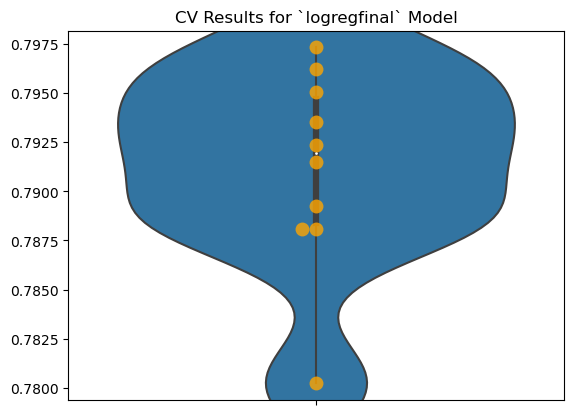

In [96]:
fig, ax = plt.subplots()

logreg_final_pipe.plot_cv(ax=ax)

In [97]:
logreg_final.fit(X_train, y_train)
logreg_final.score(X_test, y_test)

0.7961616161616162

/opt/anaconda3/envs/project-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


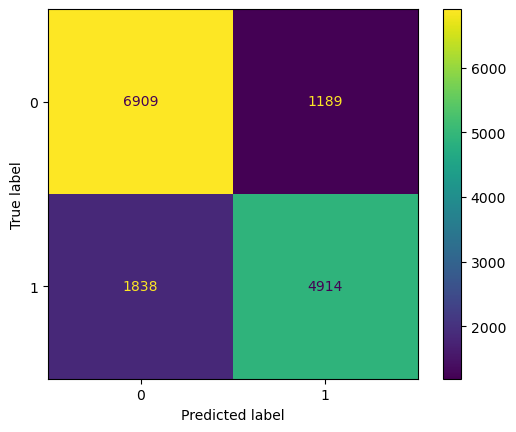

In [98]:
plot_confusion_matrix(logreg_final, X_test, y_test)

In [99]:
y_hat = logreg_final.predict(X_test)

In [100]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.8. 

Our final model's recall on the test set is 0.73 

Our final model's precision on the test set is 0.81 

Our final model's f1-score on the test is 0.76.



## Further Exploration/Questions

Is there a benefit to knowing specifically which wells need repairs but are functioning as opposed to the wells that are not functioning?

What are the limiting factors in getting resources to the wells that need repairs?
- Maintenance Professionals?
- Time?
- Money?
- Parts?
- Knowledge?